## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from openpyxl.utils import get_column_letter
import json

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [3]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-7
EPOCHS = 50
T = 10

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Data Loading

In [4]:
def load_data(*file_paths):
    """
    Returns:
        X (numpy.ndarray): Features array
        y (numpy.ndarray): Labels array
    """
    
    if len(file_paths) == 1:  # Single .npz file
        file_path = file_paths[0]
        
        if not file_path.endswith(".npz"):
            raise ValueError("Single input must be a .npz file")
            
        with np.load(file_path) as data:
            X = data["X"]
            y = data["y"]

    elif len(file_paths) == 2:  # Two .npy files
        x_path, y_path = file_paths
        
        if not (x_path.endswith(".npy") and y_path.endswith(".npy")):
            raise ValueError("When providing two inputs, both must be .npy files")
            
        X = np.load(x_path)
        y = np.load(y_path)

    return X, y

## Checking Distributions

In [5]:
def plot_input_dist(X):
    X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()
    
    for i in range(6):
        axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()


def plot_label_dist(y):
    # Checking the label distribution of training data
    print('\n\n====== Label Distribution ======')
    unique_labels, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in zip(unique_labels, counts):
        percentage = (count / total) * 100
        print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
    print(f"\nTotal samples: {total}")
    
    # Plot histogram for training data
    unique_labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Label Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Input Preprocessing

In [6]:
def normalize(X):
    # Standardizing the input features across all timesteps and samples using Z-scores
    # Compute per-feature mean and std across all samples and timesteps
    feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
    feature_stds = X.std(axis=(0, 1))    # Shape: (6,)
    
    # Reshape for broadcasting
    feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
    feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)
    
    # Standardize
    X = ((X - feature_means) / feature_stds).astype(np.float32)
    return X

## Dataset Class

In [7]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model

In [8]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)
        self.dropout = nn.Dropout(p=0.3)

In [9]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

## Evaluation

In [10]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [11]:
def evaluate(model, dataloader, class_weights=None, T=T, device=DEVICE):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, kl = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Loss Calculation
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl
            val_loss += loss.item() * x_batch.size(0)
            

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    val_loss /= len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return val_loss, acc, kappa, per_class_f1, avg_f1, cm

## Training

In [12]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [13]:
def train(model, train_dataset, train_dataloader, val_dataset, val_dataloader, class_weights=None, EPOCHS=EPOCHS, T=T):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s, val_per_class_f1s, val_kappas = [], [], []

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss, val_acc, kappa, per_class_f1, avg_f1, _ = evaluate(
            model, val_dataloader, class_weights=class_weights, T=T, device=DEVICE
        )

        scheduler.step(val_loss)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_kappas.append(kappa)
        val_f1s.append(avg_f1)
        val_per_class_f1s.append(per_class_f1)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"F1: {avg_f1:.4f}, Kappa: {kappa:.4f}")  

    return train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s

## Plotting

In [14]:
def plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))  

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1s, label='Val F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Saving Results

In [15]:
def save_results(output_file, history):
    # ensure .xlsx extension
    if not output_file.lower().endswith(".xlsx"):
        output_file = output_file + ".xlsx"

    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for file_name, h in history.items():
            # ---------------------------
            # Per-epoch logs
            # ---------------------------
            df_epochs = pd.DataFrame({
                "epoch": list(range(1, len(h["train_loss"]) + 1)),
                "train_loss": h["train_loss"],
                "train_acc": h["train_acc"],
                "val_loss": h["val_loss"],
                "val_acc": h["val_acc"],
                "val_f1": h["val_f1s"],
                "val_kappa": h["val_kappas"],
                "val_per_class_f1": [
                    ",".join(map(str, f1s)) if f1s is not None else None 
                    for f1s in h["val_per_class_f1s"]
                ]
            })

            # ---------------------------
            # Final test metrics
            # ---------------------------
            final_metrics = {
                "metric": [
                    "overall_loss",
                    "overall_acc",
                    "kappa",
                    "avg_f1",
                    "per_class_f1",
                    "cm"
                ],
                "value": [
                    h["overall_loss"],
                    h["overall_acc"],
                    h["kappa"],
                    h["avg_f1"],
                    ",".join(map(str, h["per_class_f1"])) if h["per_class_f1"] is not None else None,
                    str(h["cm"]) if h["cm"] is not None else None
                ]
            }
            df_final = pd.DataFrame(final_metrics)

            # ---------------------------
            # Write to Excel
            # ---------------------------
            sheet_name = os.path.basename(file_name)[:31]  # Excel sheet name max length = 31
            df_epochs.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
            startrow = len(df_epochs) + 2
            df_final.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)

        # ---------------------------
        # Auto-adjust column widths
        # ---------------------------
        for sheet_name, worksheet in writer.sheets.items():
            for col_idx, col_cells in enumerate(worksheet.columns, 1):
                max_length = 0
                col_letter = get_column_letter(col_idx)
                for cell in col_cells:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                worksheet.column_dimensions[col_letter].width = max_length + 2

    print(f"Saved history of all files to {output_file}")

In [16]:
def save_history(history, name, output_dir="/kaggle/working"):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (set, tuple)):
            return list(obj)
        return obj

    # Remove ".npz" if present
    base_name = os.path.basename(name).replace(".npz", "")
    output_file = os.path.join(output_dir, f"{base_name}_history.json")

    with open(output_file, "w") as f:
        json.dump(history, f, default=convert, indent=4)

    print(f'History Dumped in file {output_file}')

## Start

In [17]:
data_dir = "/kaggle/input/data-al"
file_names = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
file_names = file_names[:4]
for name in file_names:
    print(name)
    
X_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy'
y_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy'

/kaggle/input/data-al/approx_BCNN_data_bald.npz
/kaggle/input/data-al/approx_BCNN_data_bvsb.npz
/kaggle/input/data-al/approx_BCNN_data_predictive_entropy.npz
/kaggle/input/data-al/approx_BCNN_data_variation_ratio.npz


In [18]:
history = {}

for name in file_names:
    history[name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'val_f1s': [],
        'val_kappas': [],
        'val_per_class_f1s': [],
        
        'overall_loss': None,
        'overall_acc': None,
        'kappa': None,
        'avg_f1': None,
        'per_class_f1': None,
        'cm': None
    }



====== Loading Data /kaggle/input/data-al/approx_BCNN_data_bald.npz ======
Train Data:  (14000, 28, 6) (14000,)


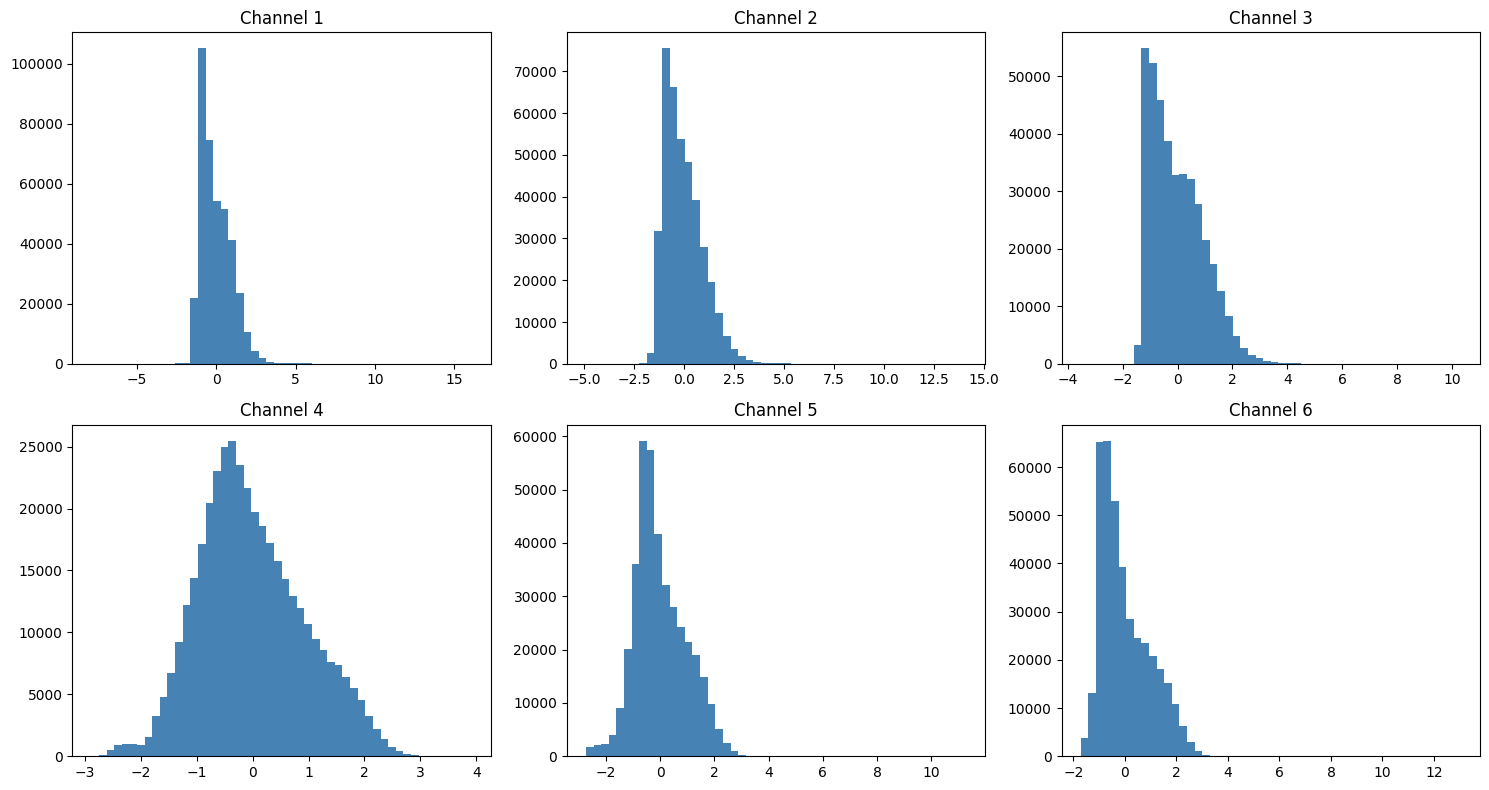

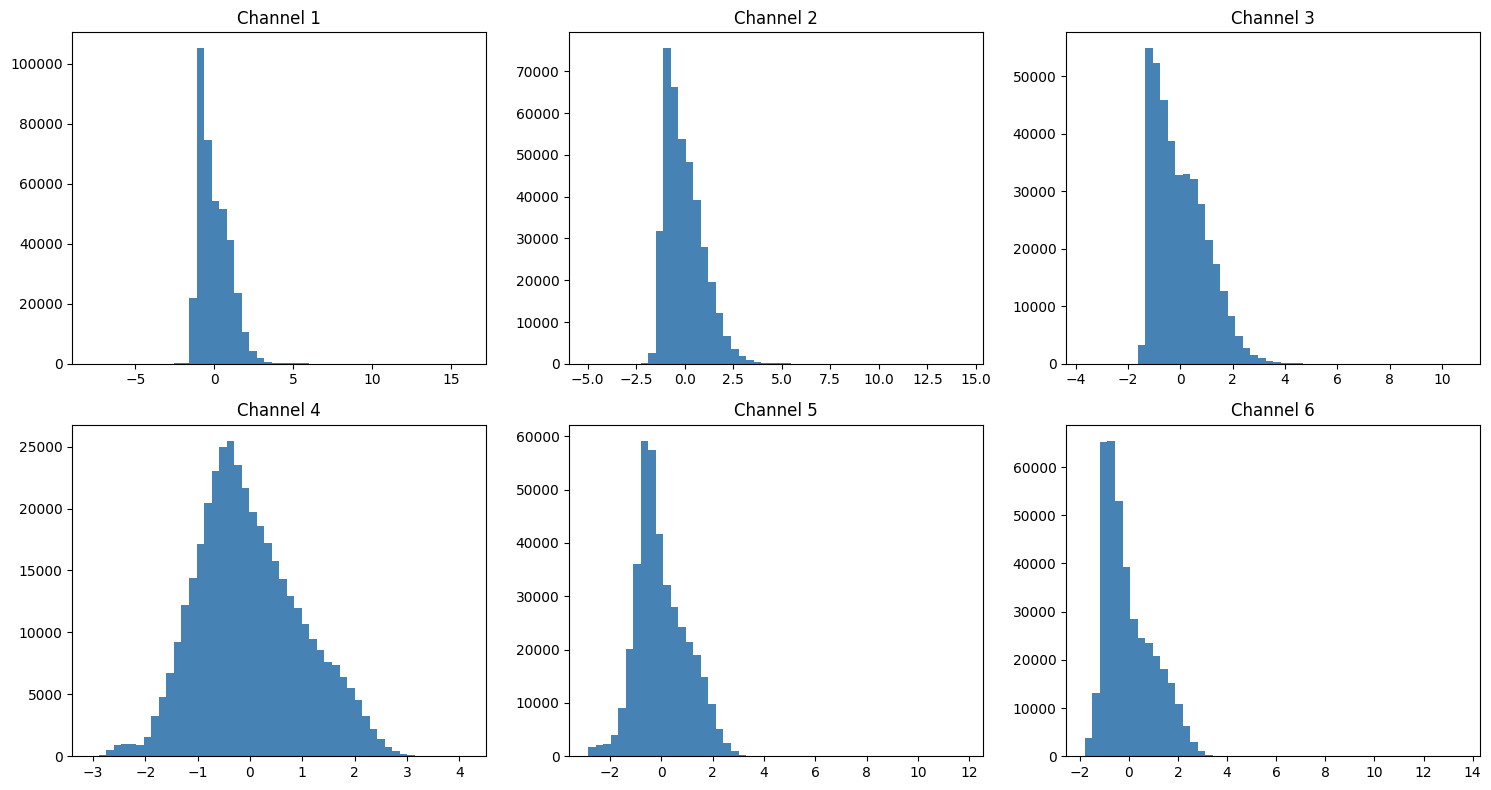



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6333      45.24%
1         2121      15.15%
2         5546      39.61%

Total samples: 14000


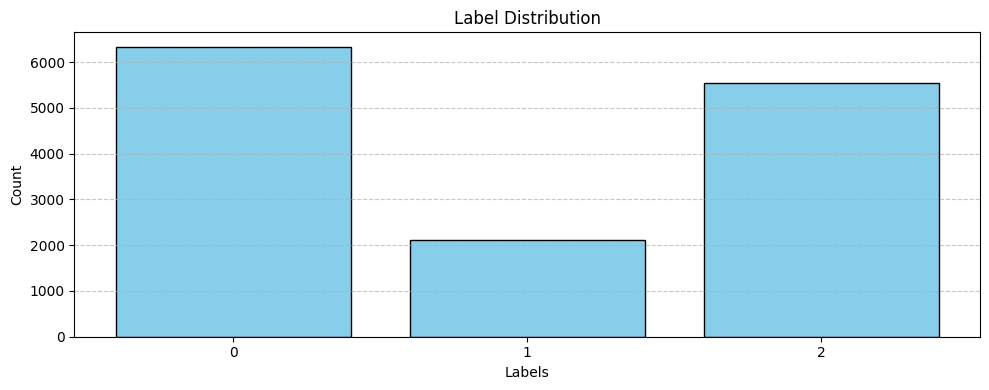


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


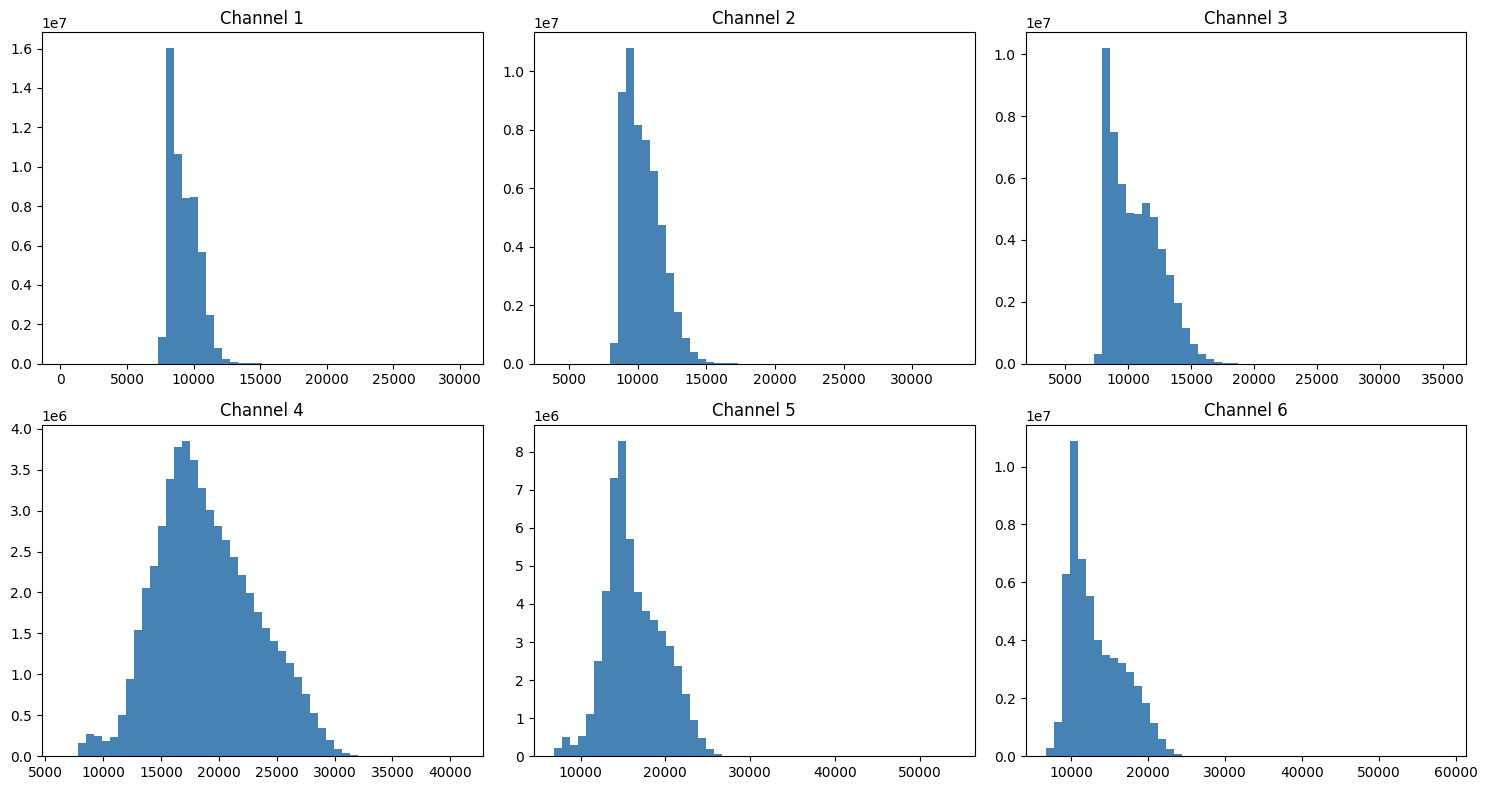

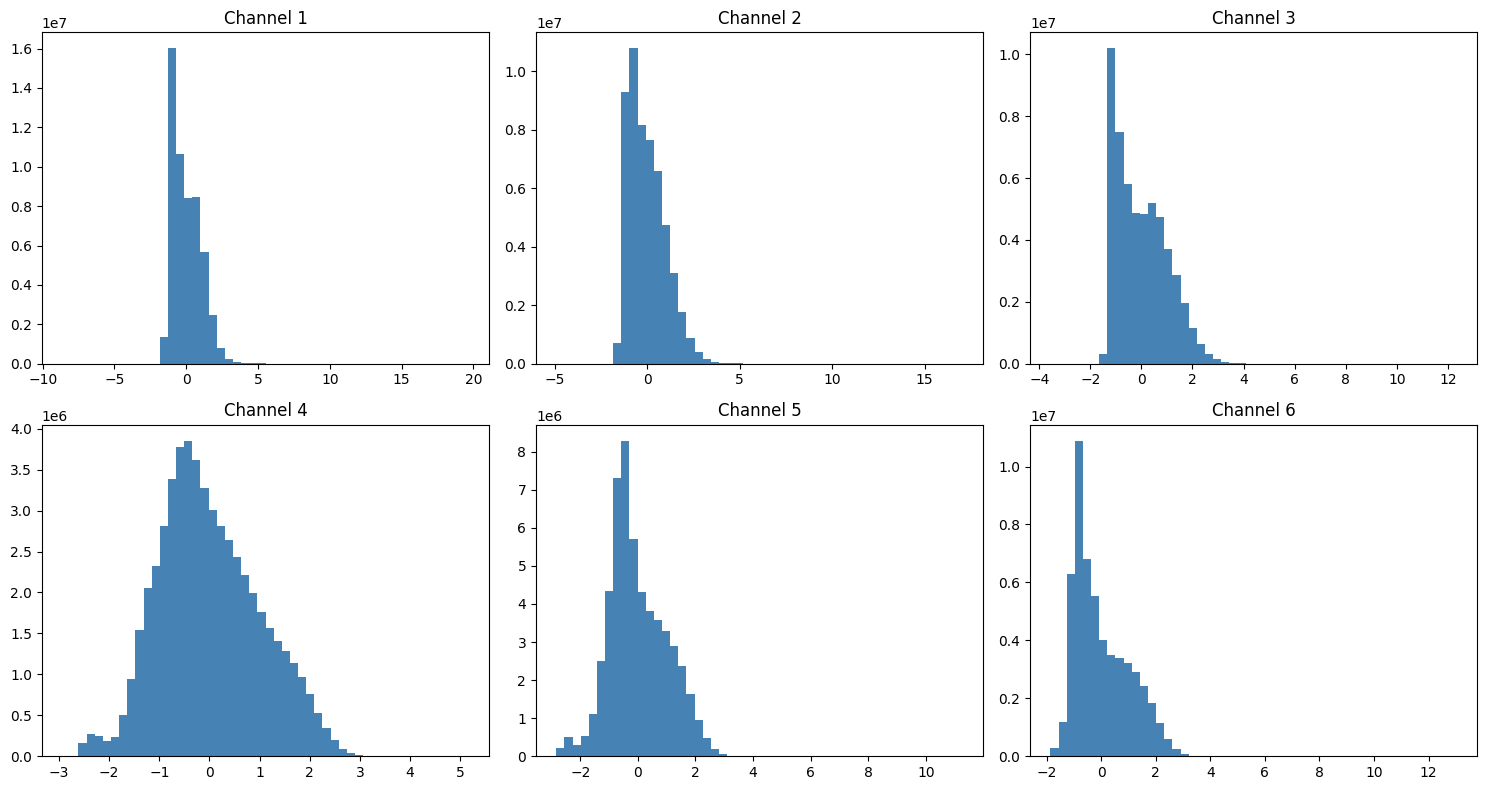



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


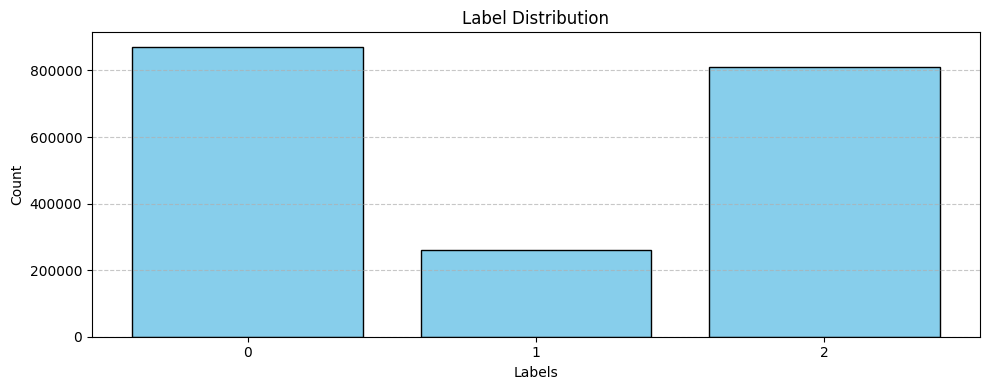

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7369, 2.2002, 0.8414], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 39.90it/s]


Loss: 0.8066 + 1e-07 * 2697736.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.77it/s]


Epoch [1/50] Train Loss: 1.3319, Train Acc: 0.5600 | Val Loss: 0.7124, Val Acc: 0.8316, F1: 0.8341, Kappa: 0.7259


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.7159 + 1e-07 * 2517519.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.71it/s]


Epoch [2/50] Train Loss: 1.0677, Train Acc: 0.6054 | Val Loss: 0.6488, Val Acc: 0.8659, F1: 0.8662, Kappa: 0.7806


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 43.16it/s]


Loss: 0.6964 + 1e-07 * 2344563.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.09it/s]


Epoch [3/50] Train Loss: 1.0054, Train Acc: 0.6291 | Val Loss: 0.5828, Val Acc: 0.8726, F1: 0.8728, Kappa: 0.7918


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.5658 + 1e-07 * 2187460.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [4/50] Train Loss: 0.9702, Train Acc: 0.6414 | Val Loss: 0.5626, Val Acc: 0.8744, F1: 0.8746, Kappa: 0.7947


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6749 + 1e-07 * 2046283.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.86it/s]


Epoch [5/50] Train Loss: 0.9380, Train Acc: 0.6501 | Val Loss: 0.5280, Val Acc: 0.8758, F1: 0.8731, Kappa: 0.7981


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.5613 + 1e-07 * 1921431.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.72it/s]


Epoch [6/50] Train Loss: 0.9091, Train Acc: 0.6569 | Val Loss: 0.5016, Val Acc: 0.8830, F1: 0.8812, Kappa: 0.8090


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.6512 + 1e-07 * 1812803.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.98it/s]


Epoch [7/50] Train Loss: 0.8801, Train Acc: 0.6644 | Val Loss: 0.4896, Val Acc: 0.8804, F1: 0.8775, Kappa: 0.8055


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.6193 + 1e-07 * 1714370.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.91it/s]


Epoch [8/50] Train Loss: 0.8657, Train Acc: 0.6666 | Val Loss: 0.4737, Val Acc: 0.8837, F1: 0.8813, Kappa: 0.8104


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.6111 + 1e-07 * 1630575.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.54it/s]


Epoch [9/50] Train Loss: 0.8463, Train Acc: 0.6757 | Val Loss: 0.4495, Val Acc: 0.8885, F1: 0.8875, Kappa: 0.8178


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.8102 + 1e-07 * 1553749.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.68it/s]


Epoch [10/50] Train Loss: 0.8316, Train Acc: 0.6781 | Val Loss: 0.4430, Val Acc: 0.8922, F1: 0.8914, Kappa: 0.8236


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.7751 + 1e-07 * 1484213.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.09it/s]


Epoch [11/50] Train Loss: 0.8177, Train Acc: 0.6798 | Val Loss: 0.4245, Val Acc: 0.8921, F1: 0.8889, Kappa: 0.8239


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6821 + 1e-07 * 1424921.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.84it/s]


Epoch [12/50] Train Loss: 0.8051, Train Acc: 0.6849 | Val Loss: 0.4169, Val Acc: 0.8888, F1: 0.8866, Kappa: 0.8186


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.6011 + 1e-07 * 1371990.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.44it/s]


Epoch [13/50] Train Loss: 0.7920, Train Acc: 0.6864 | Val Loss: 0.4128, Val Acc: 0.8957, F1: 0.8961, Kappa: 0.8290


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6587 + 1e-07 * 1320996.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.10it/s]


Epoch [14/50] Train Loss: 0.7817, Train Acc: 0.6885 | Val Loss: 0.4115, Val Acc: 0.8905, F1: 0.8900, Kappa: 0.8210


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.7046 + 1e-07 * 1275369.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.66it/s]


Epoch [15/50] Train Loss: 0.7734, Train Acc: 0.6968 | Val Loss: 0.3978, Val Acc: 0.8947, F1: 0.8951, Kappa: 0.8278


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.7055 + 1e-07 * 1234619.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.29it/s]


Epoch [16/50] Train Loss: 0.7634, Train Acc: 0.6931 | Val Loss: 0.3952, Val Acc: 0.8968, F1: 0.8986, Kappa: 0.8305


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.6867 + 1e-07 * 1195160.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.92it/s]


Epoch [17/50] Train Loss: 0.7526, Train Acc: 0.6955 | Val Loss: 0.3821, Val Acc: 0.8988, F1: 0.8985, Kappa: 0.8342


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.6430 + 1e-07 * 1160563.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.73it/s]


Epoch [18/50] Train Loss: 0.7504, Train Acc: 0.6946 | Val Loss: 0.3919, Val Acc: 0.9002, F1: 0.9014, Kappa: 0.8359


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.7323 + 1e-07 * 1130195.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.62it/s]


Epoch [19/50] Train Loss: 0.7468, Train Acc: 0.6981 | Val Loss: 0.3695, Val Acc: 0.8990, F1: 0.8983, Kappa: 0.8348


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.4648 + 1e-07 * 1100706.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.94it/s]


Epoch [20/50] Train Loss: 0.7334, Train Acc: 0.7006 | Val Loss: 0.3664, Val Acc: 0.9006, F1: 0.9013, Kappa: 0.8372


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.6703 + 1e-07 * 1072875.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.28it/s]


Epoch [21/50] Train Loss: 0.7273, Train Acc: 0.7004 | Val Loss: 0.3702, Val Acc: 0.8869, F1: 0.8838, Kappa: 0.8159


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.6246 + 1e-07 * 1047953.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.52it/s]


Epoch [22/50] Train Loss: 0.7283, Train Acc: 0.7040 | Val Loss: 0.3660, Val Acc: 0.8987, F1: 0.8996, Kappa: 0.8338


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.6652 + 1e-07 * 1027187.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.50it/s]


Epoch [23/50] Train Loss: 0.7196, Train Acc: 0.7031 | Val Loss: 0.3702, Val Acc: 0.8919, F1: 0.8921, Kappa: 0.8230


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.6340 + 1e-07 * 1005891.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.42it/s]


Epoch [24/50] Train Loss: 0.7152, Train Acc: 0.7038 | Val Loss: 0.3547, Val Acc: 0.8941, F1: 0.8930, Kappa: 0.8269


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.6452 + 1e-07 * 986364.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.97it/s]


Epoch [25/50] Train Loss: 0.7111, Train Acc: 0.7051 | Val Loss: 0.3510, Val Acc: 0.8991, F1: 0.9002, Kappa: 0.8347


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.5071 + 1e-07 * 968488.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.29it/s]


Epoch [26/50] Train Loss: 0.7081, Train Acc: 0.7109 | Val Loss: 0.3686, Val Acc: 0.8863, F1: 0.8859, Kappa: 0.8144


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.7738 + 1e-07 * 951588.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.49it/s]


Epoch [27/50] Train Loss: 0.7063, Train Acc: 0.7119 | Val Loss: 0.3640, Val Acc: 0.8928, F1: 0.8938, Kappa: 0.8243


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.6016 + 1e-07 * 936114.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.19it/s]


Epoch [28/50] Train Loss: 0.6993, Train Acc: 0.7157 | Val Loss: 0.3497, Val Acc: 0.8998, F1: 0.9008, Kappa: 0.8353


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7965 + 1e-07 * 922392.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.10it/s]


Epoch [29/50] Train Loss: 0.6946, Train Acc: 0.7147 | Val Loss: 0.3430, Val Acc: 0.8991, F1: 0.8992, Kappa: 0.8347


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.6767 + 1e-07 * 907879.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.19it/s]


Epoch [30/50] Train Loss: 0.6917, Train Acc: 0.7149 | Val Loss: 0.3463, Val Acc: 0.8977, F1: 0.8985, Kappa: 0.8324


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.6608 + 1e-07 * 894667.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.40it/s]


Epoch [31/50] Train Loss: 0.6852, Train Acc: 0.7150 | Val Loss: 0.3377, Val Acc: 0.8956, F1: 0.8948, Kappa: 0.8293


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.4923 + 1e-07 * 882715.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.84it/s]


Epoch [32/50] Train Loss: 0.6856, Train Acc: 0.7166 | Val Loss: 0.3470, Val Acc: 0.9001, F1: 0.9005, Kappa: 0.8364


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.5571 + 1e-07 * 871226.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.34it/s]


Epoch [33/50] Train Loss: 0.6844, Train Acc: 0.7161 | Val Loss: 0.3444, Val Acc: 0.8917, F1: 0.8895, Kappa: 0.8232


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.3834 + 1e-07 * 862181.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.64it/s]


Epoch [34/50] Train Loss: 0.6720, Train Acc: 0.7166 | Val Loss: 0.3385, Val Acc: 0.8938, F1: 0.8922, Kappa: 0.8264


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.6809 + 1e-07 * 853876.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.77it/s]


Epoch [35/50] Train Loss: 0.6810, Train Acc: 0.7167 | Val Loss: 0.3382, Val Acc: 0.8966, F1: 0.8967, Kappa: 0.8305


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.6457 + 1e-07 * 844433.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.56it/s]


Epoch [36/50] Train Loss: 0.6717, Train Acc: 0.7201 | Val Loss: 0.3436, Val Acc: 0.8880, F1: 0.8924, Kappa: 0.8165


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 43.16it/s]


Loss: 0.6393 + 1e-07 * 836279.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.94it/s]


Epoch [37/50] Train Loss: 0.6746, Train Acc: 0.7224 | Val Loss: 0.3344, Val Acc: 0.8978, F1: 0.8989, Kappa: 0.8328


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.6302 + 1e-07 * 828303.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.47it/s]


Epoch [38/50] Train Loss: 0.6730, Train Acc: 0.7189 | Val Loss: 0.3321, Val Acc: 0.8983, F1: 0.8978, Kappa: 0.8336


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.5179 + 1e-07 * 820875.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.32it/s]


Epoch [39/50] Train Loss: 0.6723, Train Acc: 0.7139 | Val Loss: 0.3392, Val Acc: 0.8943, F1: 0.8913, Kappa: 0.8274


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.5179 + 1e-07 * 813555.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.84it/s]


Epoch [40/50] Train Loss: 0.6636, Train Acc: 0.7194 | Val Loss: 0.3386, Val Acc: 0.8976, F1: 0.8961, Kappa: 0.8326


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.5550 + 1e-07 * 805434.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.25it/s]


Epoch [41/50] Train Loss: 0.6554, Train Acc: 0.7248 | Val Loss: 0.3371, Val Acc: 0.8944, F1: 0.8932, Kappa: 0.8276


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.6544 + 1e-07 * 800604.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.09it/s]


Epoch [42/50] Train Loss: 0.6675, Train Acc: 0.7204 | Val Loss: 0.3367, Val Acc: 0.9007, F1: 0.9002, Kappa: 0.8371


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.5300 + 1e-07 * 795694.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.89it/s]


Epoch [43/50] Train Loss: 0.6673, Train Acc: 0.7206 | Val Loss: 0.3384, Val Acc: 0.9015, F1: 0.9019, Kappa: 0.8382


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.7246 + 1e-07 * 790243.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.32it/s]


Epoch [44/50] Train Loss: 0.6654, Train Acc: 0.7247 | Val Loss: 0.3298, Val Acc: 0.8990, F1: 0.8996, Kappa: 0.8343


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.5967 + 1e-07 * 784846.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.47it/s]


Epoch [45/50] Train Loss: 0.6531, Train Acc: 0.7296 | Val Loss: 0.3262, Val Acc: 0.8964, F1: 0.8945, Kappa: 0.8308


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.5318 + 1e-07 * 778488.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.18it/s]


Epoch [46/50] Train Loss: 0.6482, Train Acc: 0.7286 | Val Loss: 0.3311, Val Acc: 0.8975, F1: 0.8969, Kappa: 0.8322


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.5168 + 1e-07 * 774157.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.09it/s]


Epoch [47/50] Train Loss: 0.6524, Train Acc: 0.7317 | Val Loss: 0.3352, Val Acc: 0.8957, F1: 0.8966, Kappa: 0.8288


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.7197 + 1e-07 * 769666.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.78it/s]


Epoch [48/50] Train Loss: 0.6522, Train Acc: 0.7270 | Val Loss: 0.3283, Val Acc: 0.8929, F1: 0.8904, Kappa: 0.8254


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.5030 + 1e-07 * 767012.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.96it/s]


Epoch [49/50] Train Loss: 0.6474, Train Acc: 0.7276 | Val Loss: 0.3333, Val Acc: 0.8979, F1: 0.8989, Kappa: 0.8324


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.4255 + 1e-07 * 764706.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.57it/s]


Epoch [50/50] Train Loss: 0.6480, Train Acc: 0.7330 | Val Loss: 0.3258, Val Acc: 0.8922, F1: 0.8921, Kappa: 0.8237


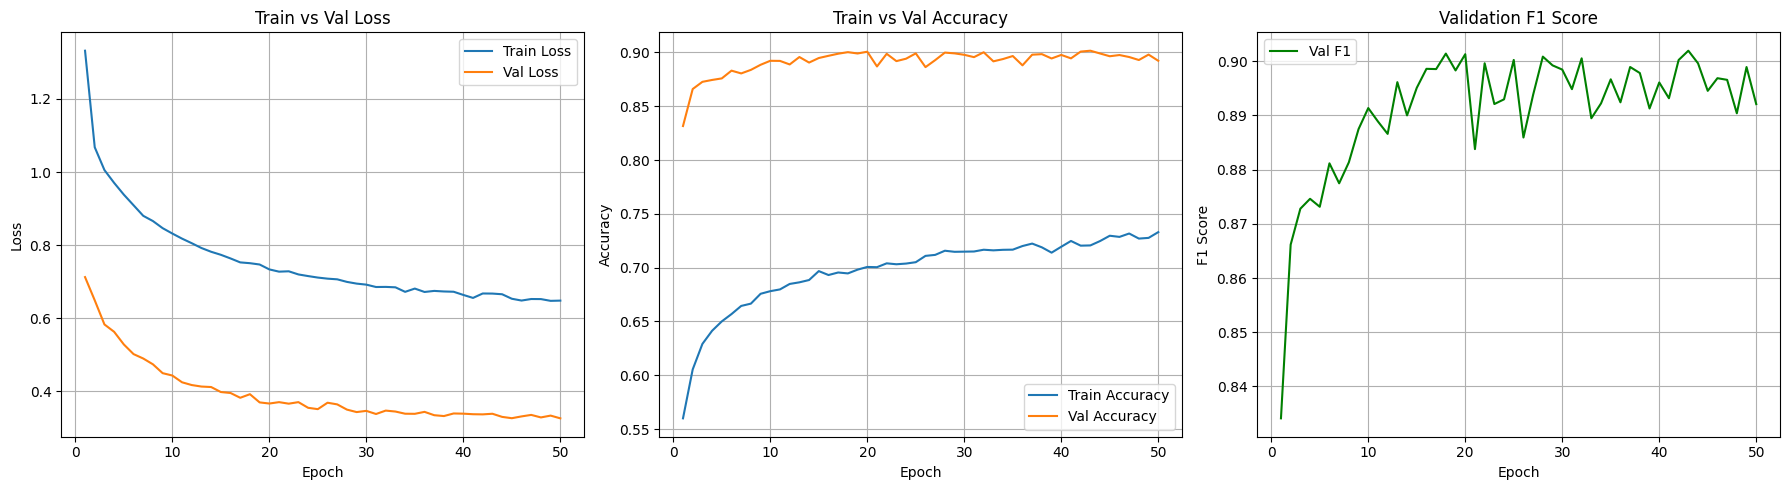


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:42<00:00, 135.98it/s]



====== Test Results ======
Overall Loss: 0.3221
Overall Accuracy: 0.8969
Cohen's Kappa: 0.8312
Per Class F1: [0.89478963 0.9003289  0.89784391]
Macro (Avg) F1: 0.8977


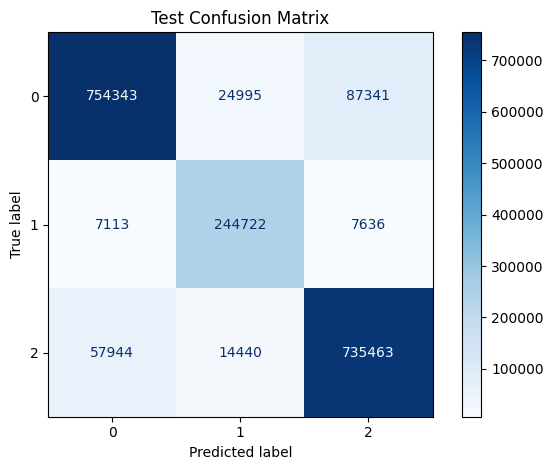

History Dumped in file /kaggle/working/approx_BCNN_data_bald_history.json


====== Loading Data /kaggle/input/data-al/approx_BCNN_data_bvsb.npz ======
Train Data:  (14000, 28, 6) (14000,)


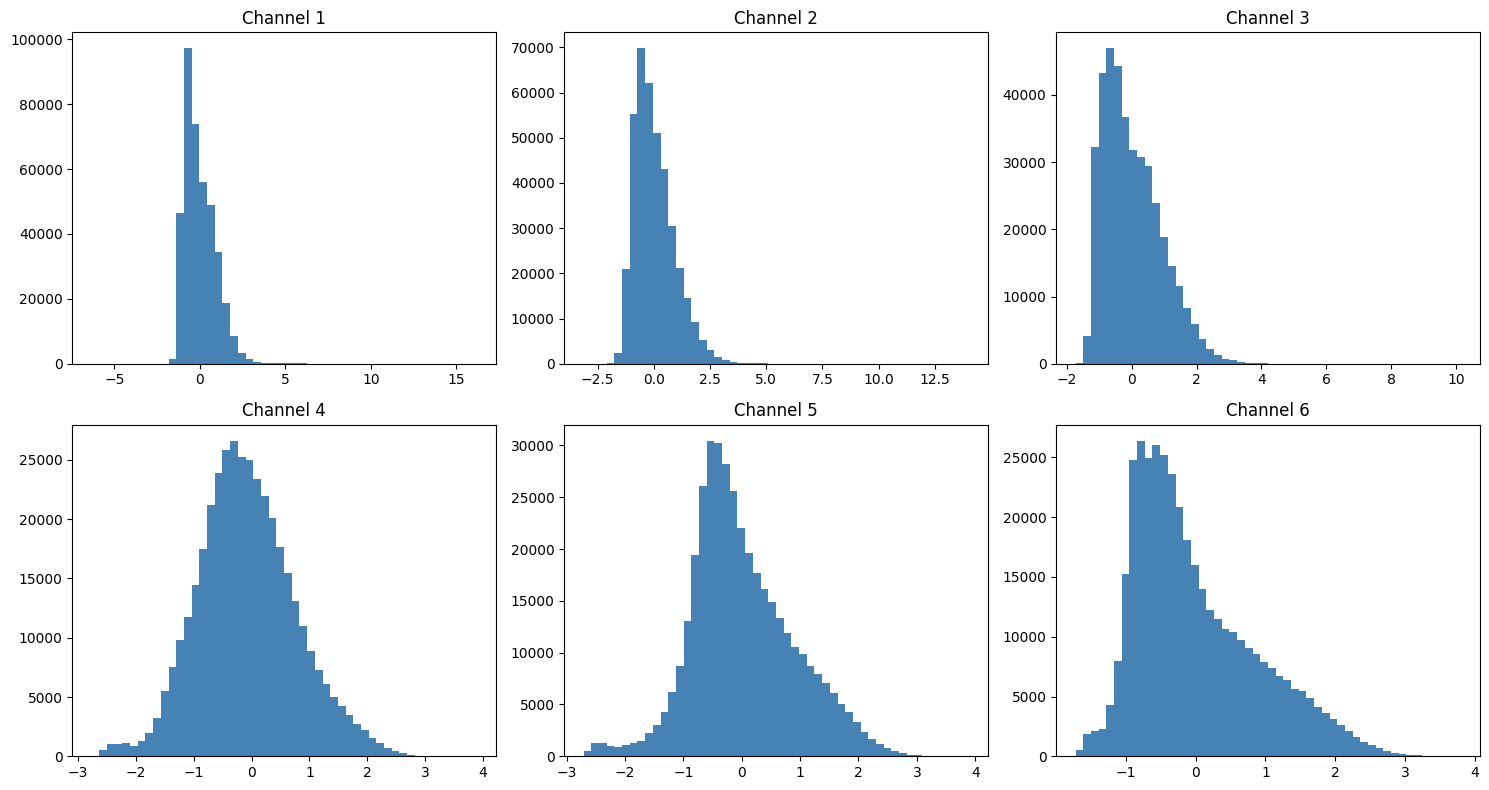

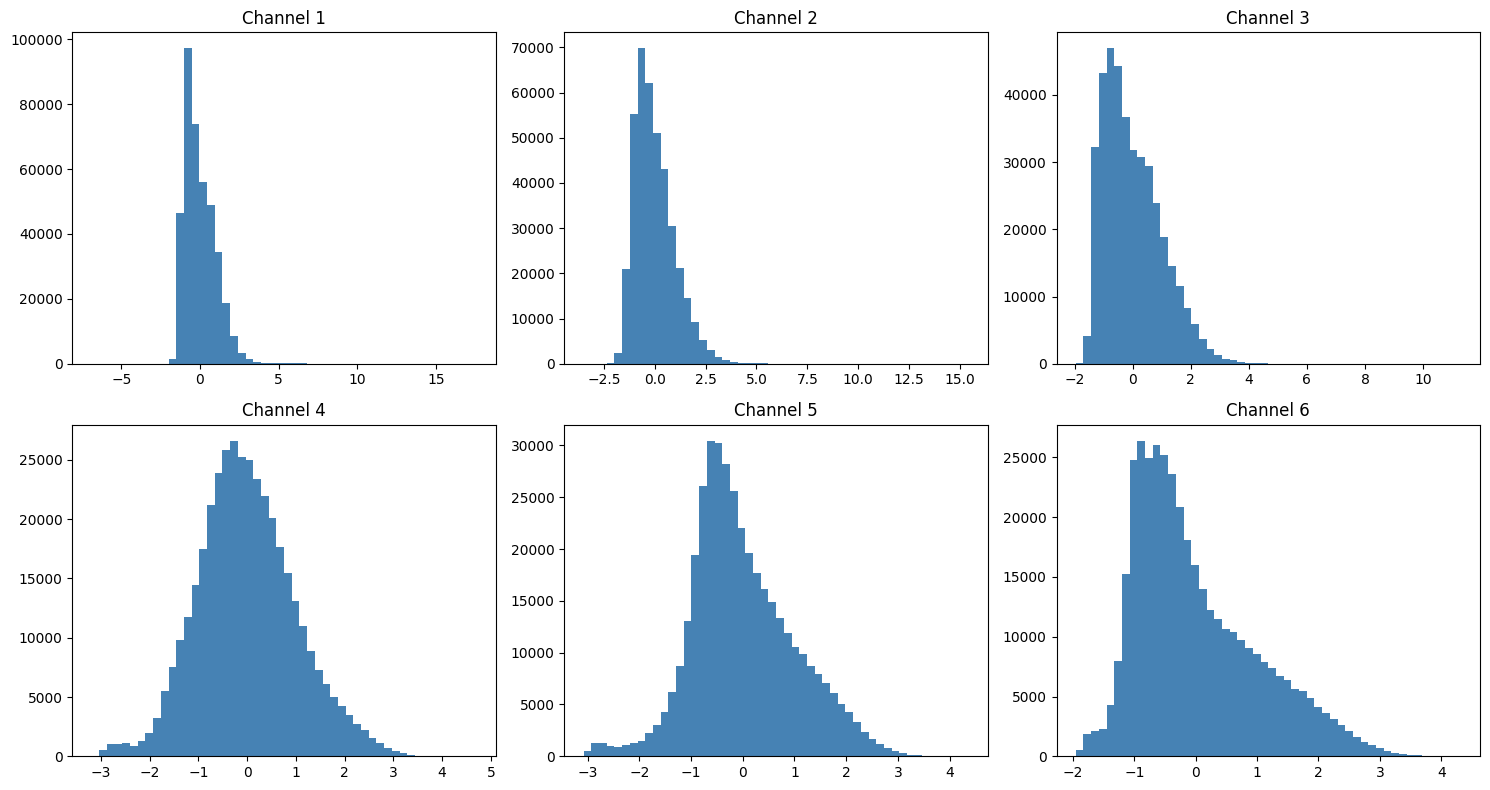



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6332      45.23%
1         1601      11.44%
2         6067      43.34%

Total samples: 14000


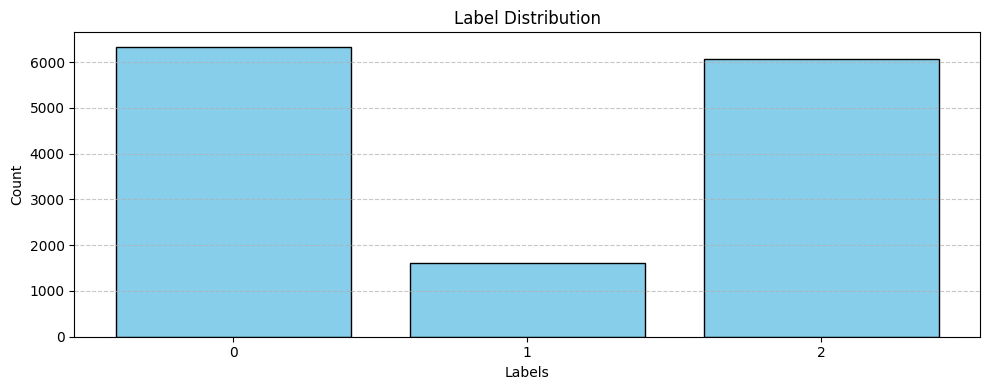


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


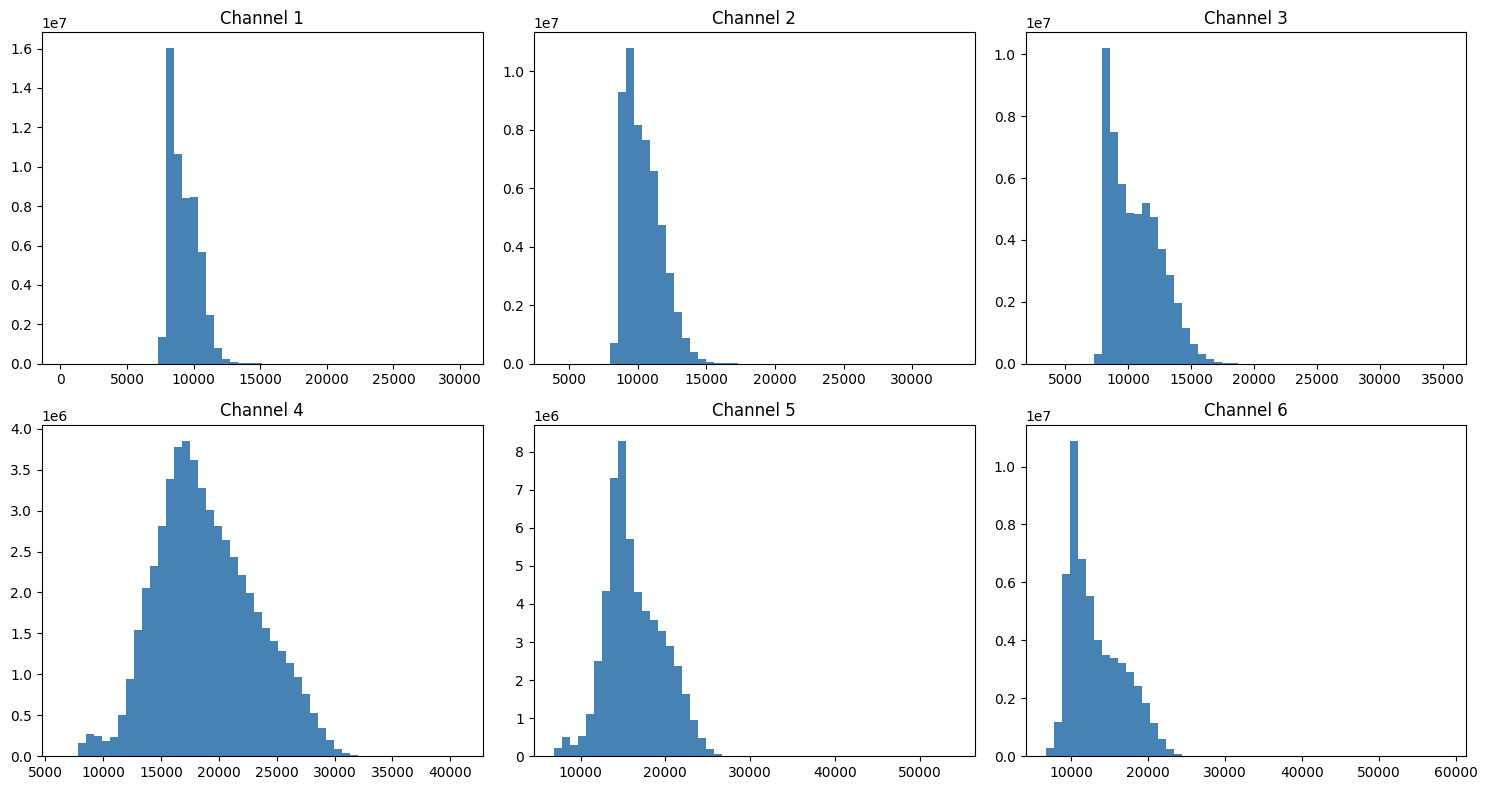

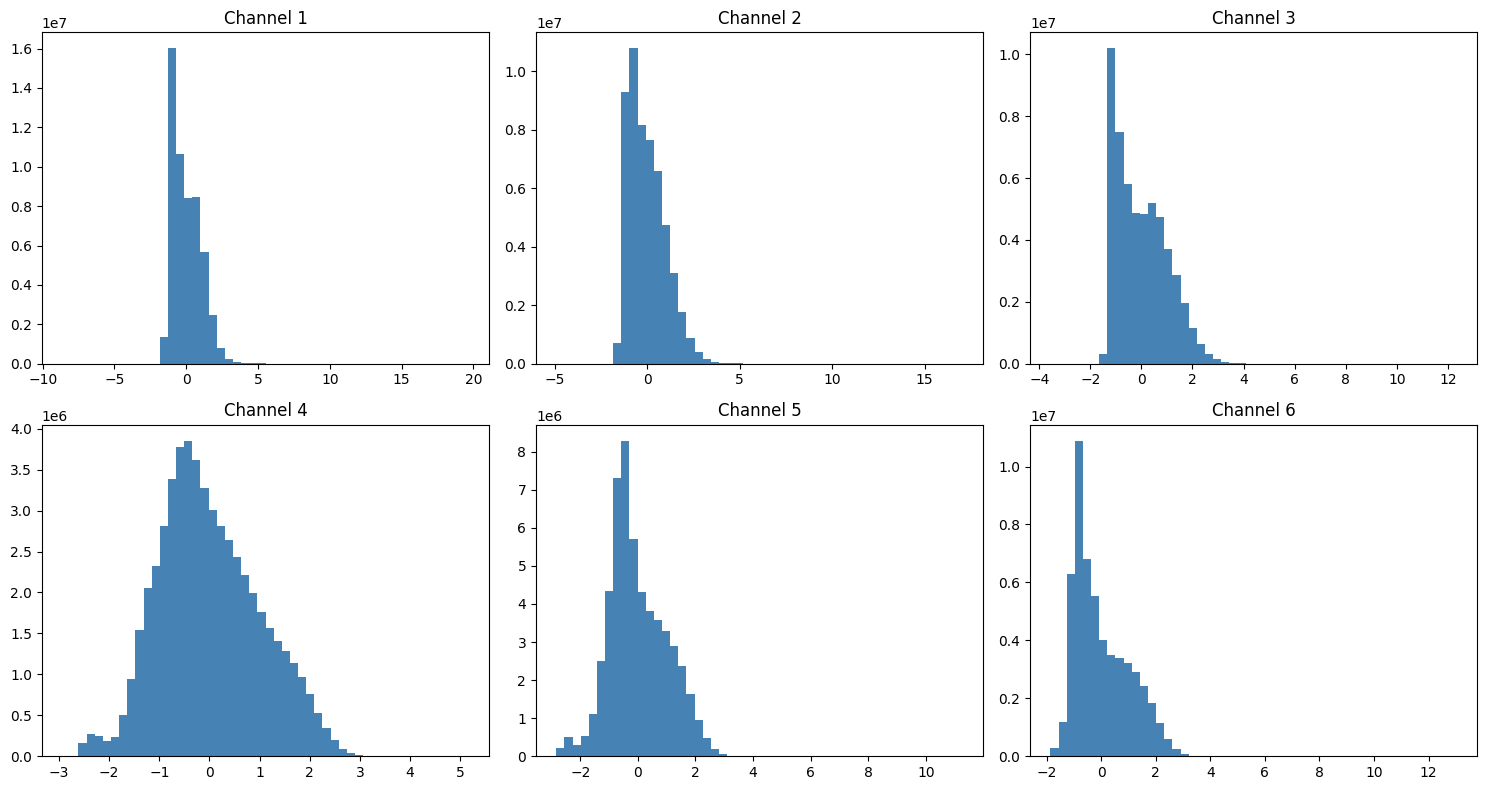



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


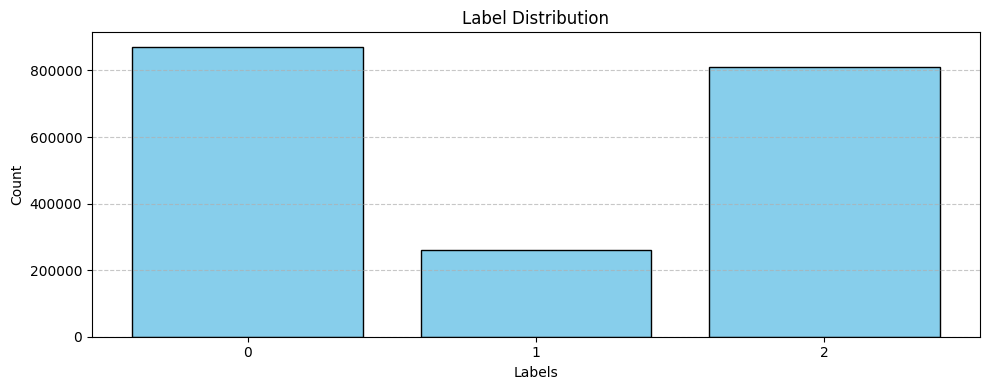

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7370, 2.9148, 0.7692], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.8443 + 1e-07 * 2706657.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [1/50] Train Loss: 1.3938, Train Acc: 0.5131 | Val Loss: 0.7431, Val Acc: 0.8052, F1: 0.8109, Kappa: 0.6819


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.8487 + 1e-07 * 2529623.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.08it/s]


Epoch [2/50] Train Loss: 1.1309, Train Acc: 0.5529 | Val Loss: 0.6769, Val Acc: 0.8329, F1: 0.8353, Kappa: 0.7272


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.7461 + 1e-07 * 2358031.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.58it/s]


Epoch [3/50] Train Loss: 1.0794, Train Acc: 0.5621 | Val Loss: 0.6303, Val Acc: 0.8485, F1: 0.8464, Kappa: 0.7550


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.6967 + 1e-07 * 2202457.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.77it/s]


Epoch [4/50] Train Loss: 1.0453, Train Acc: 0.5729 | Val Loss: 0.6132, Val Acc: 0.8538, F1: 0.8481, Kappa: 0.7636


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.8307 + 1e-07 * 2060437.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.35it/s]


Epoch [5/50] Train Loss: 1.0060, Train Acc: 0.5822 | Val Loss: 0.5943, Val Acc: 0.8578, F1: 0.8542, Kappa: 0.7694


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.9337 + 1e-07 * 1931774.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.62it/s]


Epoch [6/50] Train Loss: 0.9832, Train Acc: 0.5804 | Val Loss: 0.5635, Val Acc: 0.8569, F1: 0.8538, Kappa: 0.7678


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.7889 + 1e-07 * 1818482.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.42it/s]


Epoch [7/50] Train Loss: 0.9579, Train Acc: 0.5872 | Val Loss: 0.5569, Val Acc: 0.8668, F1: 0.8631, Kappa: 0.7837


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.8166 + 1e-07 * 1715369.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.90it/s]


Epoch [8/50] Train Loss: 0.9535, Train Acc: 0.5944 | Val Loss: 0.5517, Val Acc: 0.8465, F1: 0.8449, Kappa: 0.7509


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.7665 + 1e-07 * 1623797.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.72it/s]


Epoch [9/50] Train Loss: 0.9282, Train Acc: 0.5967 | Val Loss: 0.5215, Val Acc: 0.8591, F1: 0.8566, Kappa: 0.7712


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.6711 + 1e-07 * 1539969.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.70it/s]


Epoch [10/50] Train Loss: 0.9075, Train Acc: 0.6044 | Val Loss: 0.5269, Val Acc: 0.8725, F1: 0.8709, Kappa: 0.7921


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7142 + 1e-07 * 1466878.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.56it/s]


Epoch [11/50] Train Loss: 0.9078, Train Acc: 0.5974 | Val Loss: 0.4840, Val Acc: 0.8810, F1: 0.8781, Kappa: 0.8061


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.6868 + 1e-07 * 1402010.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.79it/s]


Epoch [12/50] Train Loss: 0.8904, Train Acc: 0.6085 | Val Loss: 0.4594, Val Acc: 0.8761, F1: 0.8742, Kappa: 0.7983


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.7931 + 1e-07 * 1340948.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.83it/s]


Epoch [13/50] Train Loss: 0.8775, Train Acc: 0.6053 | Val Loss: 0.4606, Val Acc: 0.8791, F1: 0.8756, Kappa: 0.8034


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.7958 + 1e-07 * 1287278.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.70it/s]


Epoch [14/50] Train Loss: 0.8668, Train Acc: 0.6123 | Val Loss: 0.4668, Val Acc: 0.8686, F1: 0.8638, Kappa: 0.7871


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.6859 + 1e-07 * 1240932.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.45it/s]


Epoch [15/50] Train Loss: 0.8660, Train Acc: 0.6175 | Val Loss: 0.4330, Val Acc: 0.8809, F1: 0.8763, Kappa: 0.8065


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.6858 + 1e-07 * 1198506.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.30it/s]


Epoch [16/50] Train Loss: 0.8511, Train Acc: 0.6156 | Val Loss: 0.4390, Val Acc: 0.8794, F1: 0.8756, Kappa: 0.8038


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.8787 + 1e-07 * 1160286.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.74it/s]


Epoch [17/50] Train Loss: 0.8492, Train Acc: 0.6148 | Val Loss: 0.4503, Val Acc: 0.8770, F1: 0.8713, Kappa: 0.8006


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 43.15it/s]


Loss: 0.6345 + 1e-07 * 1125493.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.40it/s]


Epoch [18/50] Train Loss: 0.8357, Train Acc: 0.6226 | Val Loss: 0.4215, Val Acc: 0.8833, F1: 0.8812, Kappa: 0.8098


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.6914 + 1e-07 * 1093496.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.31it/s]


Epoch [19/50] Train Loss: 0.8395, Train Acc: 0.6221 | Val Loss: 0.4152, Val Acc: 0.8740, F1: 0.8665, Kappa: 0.7962


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.7821 + 1e-07 * 1063114.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.16it/s]


Epoch [20/50] Train Loss: 0.8233, Train Acc: 0.6176 | Val Loss: 0.3983, Val Acc: 0.8830, F1: 0.8791, Kappa: 0.8099


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.7752 + 1e-07 * 1034744.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.70it/s]


Epoch [21/50] Train Loss: 0.8157, Train Acc: 0.6272 | Val Loss: 0.4209, Val Acc: 0.8727, F1: 0.8686, Kappa: 0.7934


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.7195 + 1e-07 * 1009416.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.40it/s]


Epoch [22/50] Train Loss: 0.8235, Train Acc: 0.6222 | Val Loss: 0.4254, Val Acc: 0.8827, F1: 0.8792, Kappa: 0.8090


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.7382 + 1e-07 * 987413.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.07it/s]


Epoch [23/50] Train Loss: 0.8049, Train Acc: 0.6240 | Val Loss: 0.4043, Val Acc: 0.8823, F1: 0.8840, Kappa: 0.8072


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.7248 + 1e-07 * 965894.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.07it/s]


Epoch [24/50] Train Loss: 0.8079, Train Acc: 0.6256 | Val Loss: 0.3969, Val Acc: 0.8856, F1: 0.8823, Kappa: 0.8138


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.7687 + 1e-07 * 944858.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.16it/s]


Epoch [25/50] Train Loss: 0.8073, Train Acc: 0.6189 | Val Loss: 0.4196, Val Acc: 0.8828, F1: 0.8815, Kappa: 0.8081


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 43.11it/s]


Loss: 0.6085 + 1e-07 * 927133.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.44it/s]


Epoch [26/50] Train Loss: 0.7972, Train Acc: 0.6223 | Val Loss: 0.4526, Val Acc: 0.8554, F1: 0.8596, Kappa: 0.7631


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.7881 + 1e-07 * 910117.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.04it/s]


Epoch [27/50] Train Loss: 0.7954, Train Acc: 0.6304 | Val Loss: 0.4005, Val Acc: 0.8883, F1: 0.8865, Kappa: 0.8174


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.6306 + 1e-07 * 894187.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.12it/s]


Epoch [28/50] Train Loss: 0.7962, Train Acc: 0.6351 | Val Loss: 0.3905, Val Acc: 0.8840, F1: 0.8805, Kappa: 0.8112


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.6442 + 1e-07 * 880373.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.96it/s]


Epoch [29/50] Train Loss: 0.7841, Train Acc: 0.6326 | Val Loss: 0.3707, Val Acc: 0.8924, F1: 0.8893, Kappa: 0.8246


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.8470 + 1e-07 * 868596.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.59it/s]


Epoch [30/50] Train Loss: 0.7888, Train Acc: 0.6269 | Val Loss: 0.3941, Val Acc: 0.8804, F1: 0.8785, Kappa: 0.8049


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.6012 + 1e-07 * 855579.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.58it/s]


Epoch [31/50] Train Loss: 0.7759, Train Acc: 0.6315 | Val Loss: 0.3783, Val Acc: 0.8851, F1: 0.8843, Kappa: 0.8122


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.6176 + 1e-07 * 843188.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.01it/s]


Epoch [32/50] Train Loss: 0.7733, Train Acc: 0.6369 | Val Loss: 0.3888, Val Acc: 0.8930, F1: 0.8889, Kappa: 0.8253


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 41.41it/s]


Loss: 0.6666 + 1e-07 * 833448.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.44it/s]


Epoch [33/50] Train Loss: 0.7818, Train Acc: 0.6379 | Val Loss: 0.3713, Val Acc: 0.8844, F1: 0.8800, Kappa: 0.8116


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.5838 + 1e-07 * 823347.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.05it/s]


Epoch [34/50] Train Loss: 0.7744, Train Acc: 0.6324 | Val Loss: 0.3859, Val Acc: 0.8791, F1: 0.8767, Kappa: 0.8031


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.5242 + 1e-07 * 816086.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.94it/s]


Epoch [35/50] Train Loss: 0.7702, Train Acc: 0.6367 | Val Loss: 0.3959, Val Acc: 0.8717, F1: 0.8723, Kappa: 0.7904


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.7157 + 1e-07 * 806966.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.29it/s]


Epoch [36/50] Train Loss: 0.7576, Train Acc: 0.6510 | Val Loss: 0.3669, Val Acc: 0.8910, F1: 0.8891, Kappa: 0.8221


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 0.6358 + 1e-07 * 798919.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.86it/s]


Epoch [37/50] Train Loss: 0.7570, Train Acc: 0.6491 | Val Loss: 0.3638, Val Acc: 0.8894, F1: 0.8867, Kappa: 0.8198


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.6497 + 1e-07 * 791571.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.42it/s]


Epoch [38/50] Train Loss: 0.7538, Train Acc: 0.6440 | Val Loss: 0.3625, Val Acc: 0.8931, F1: 0.8922, Kappa: 0.8250


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.4829 + 1e-07 * 784797.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.44it/s]


Epoch [39/50] Train Loss: 0.7525, Train Acc: 0.6510 | Val Loss: 0.3670, Val Acc: 0.8891, F1: 0.8851, Kappa: 0.8194


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 1.1554 + 1e-07 * 778693.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.74it/s]


Epoch [40/50] Train Loss: 0.7475, Train Acc: 0.6531 | Val Loss: 0.3541, Val Acc: 0.8904, F1: 0.8870, Kappa: 0.8214


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.6613 + 1e-07 * 773283.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.95it/s]


Epoch [41/50] Train Loss: 0.7520, Train Acc: 0.6386 | Val Loss: 0.3616, Val Acc: 0.8891, F1: 0.8874, Kappa: 0.8188


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 0.6450 + 1e-07 * 767557.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.45it/s]


Epoch [42/50] Train Loss: 0.7507, Train Acc: 0.6469 | Val Loss: 0.3561, Val Acc: 0.8857, F1: 0.8811, Kappa: 0.8141


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.7325 + 1e-07 * 762603.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.19it/s]


Epoch [43/50] Train Loss: 0.7480, Train Acc: 0.6490 | Val Loss: 0.3657, Val Acc: 0.8850, F1: 0.8833, Kappa: 0.8124


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.6660 + 1e-07 * 758054.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.26it/s]


Epoch [44/50] Train Loss: 0.7407, Train Acc: 0.6500 | Val Loss: 0.3597, Val Acc: 0.8907, F1: 0.8906, Kappa: 0.8209


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.6946 + 1e-07 * 753384.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.38it/s]


Epoch [45/50] Train Loss: 0.7433, Train Acc: 0.6481 | Val Loss: 0.3736, Val Acc: 0.8805, F1: 0.8815, Kappa: 0.8043


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.5742 + 1e-07 * 748768.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.99it/s]


Epoch [46/50] Train Loss: 0.7367, Train Acc: 0.6514 | Val Loss: 0.3559, Val Acc: 0.8882, F1: 0.8857, Kappa: 0.8175


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.6678 + 1e-07 * 745676.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.57it/s]


Epoch [47/50] Train Loss: 0.7311, Train Acc: 0.6523 | Val Loss: 0.3441, Val Acc: 0.8926, F1: 0.8905, Kappa: 0.8247


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.5364 + 1e-07 * 742710.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.67it/s]


Epoch [48/50] Train Loss: 0.7351, Train Acc: 0.6505 | Val Loss: 0.3501, Val Acc: 0.8893, F1: 0.8867, Kappa: 0.8191


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.7996 + 1e-07 * 739751.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.67it/s]


Epoch [49/50] Train Loss: 0.7273, Train Acc: 0.6574 | Val Loss: 0.3508, Val Acc: 0.8937, F1: 0.8917, Kappa: 0.8263


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.5204 + 1e-07 * 736844.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.84it/s]


Epoch [50/50] Train Loss: 0.7325, Train Acc: 0.6506 | Val Loss: 0.3446, Val Acc: 0.8926, F1: 0.8921, Kappa: 0.8244


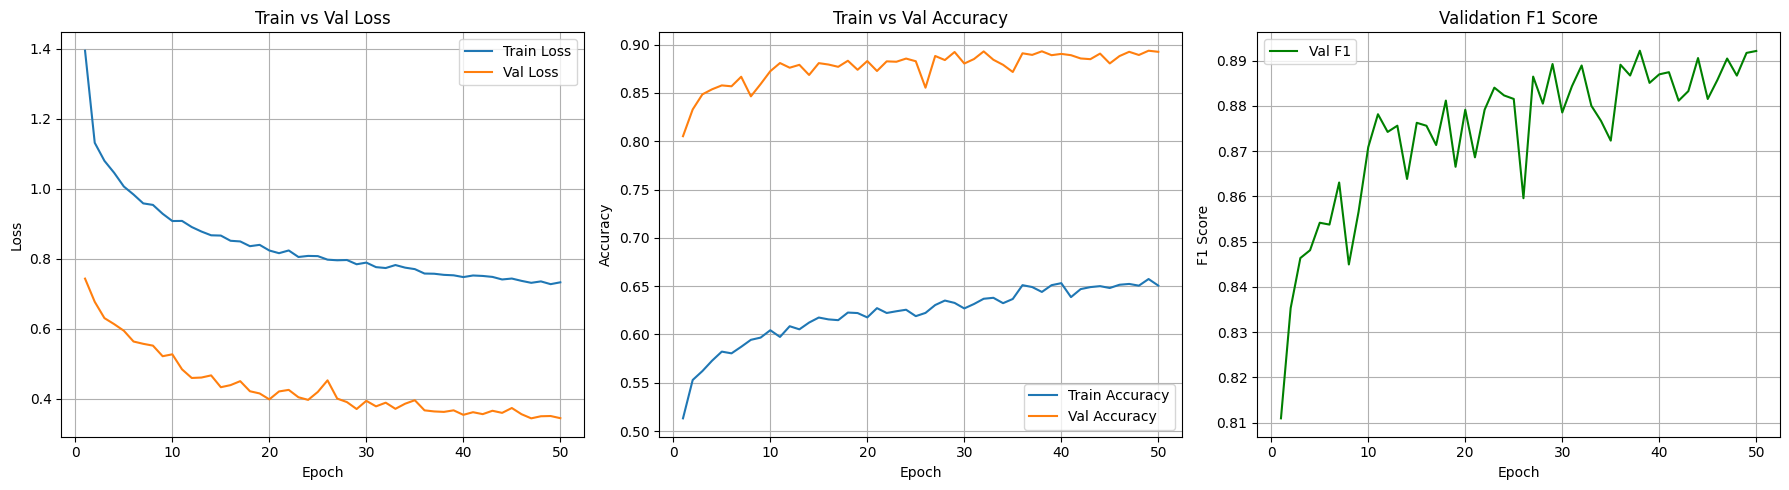


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:41<00:00, 136.48it/s]



====== Test Results ======
Overall Loss: 0.3421
Overall Accuracy: 0.8944
Cohen's Kappa: 0.8272
Per Class F1: [0.89507284 0.89159368 0.8946319 ]
Macro (Avg) F1: 0.8938


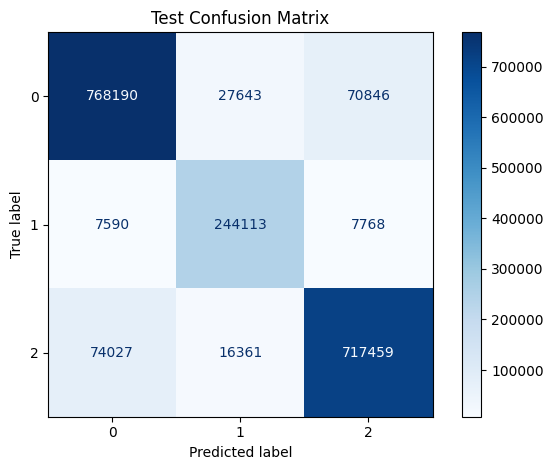

History Dumped in file /kaggle/working/approx_BCNN_data_bvsb_history.json


====== Loading Data /kaggle/input/data-al/approx_BCNN_data_predictive_entropy.npz ======
Train Data:  (14000, 28, 6) (14000,)


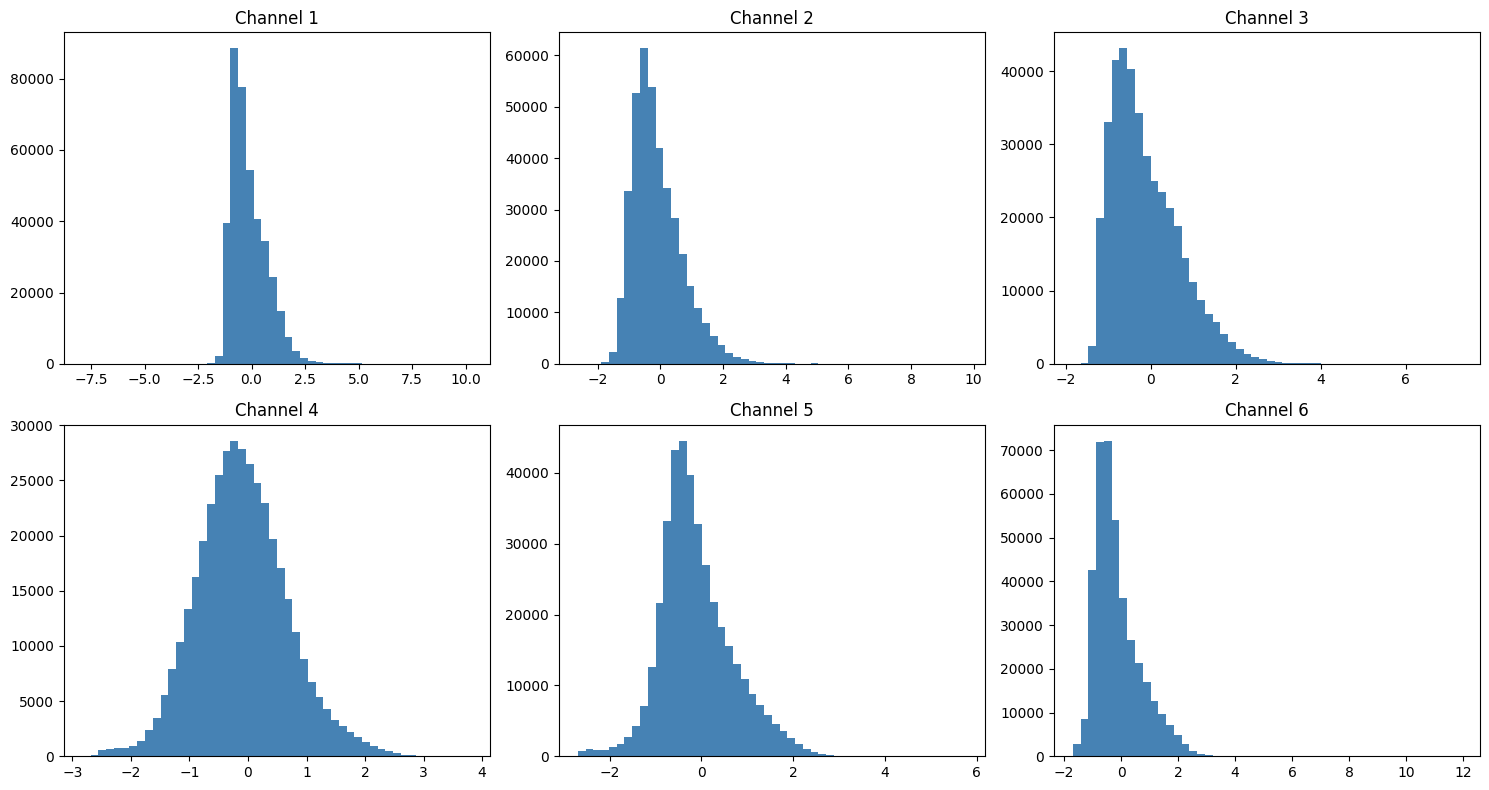

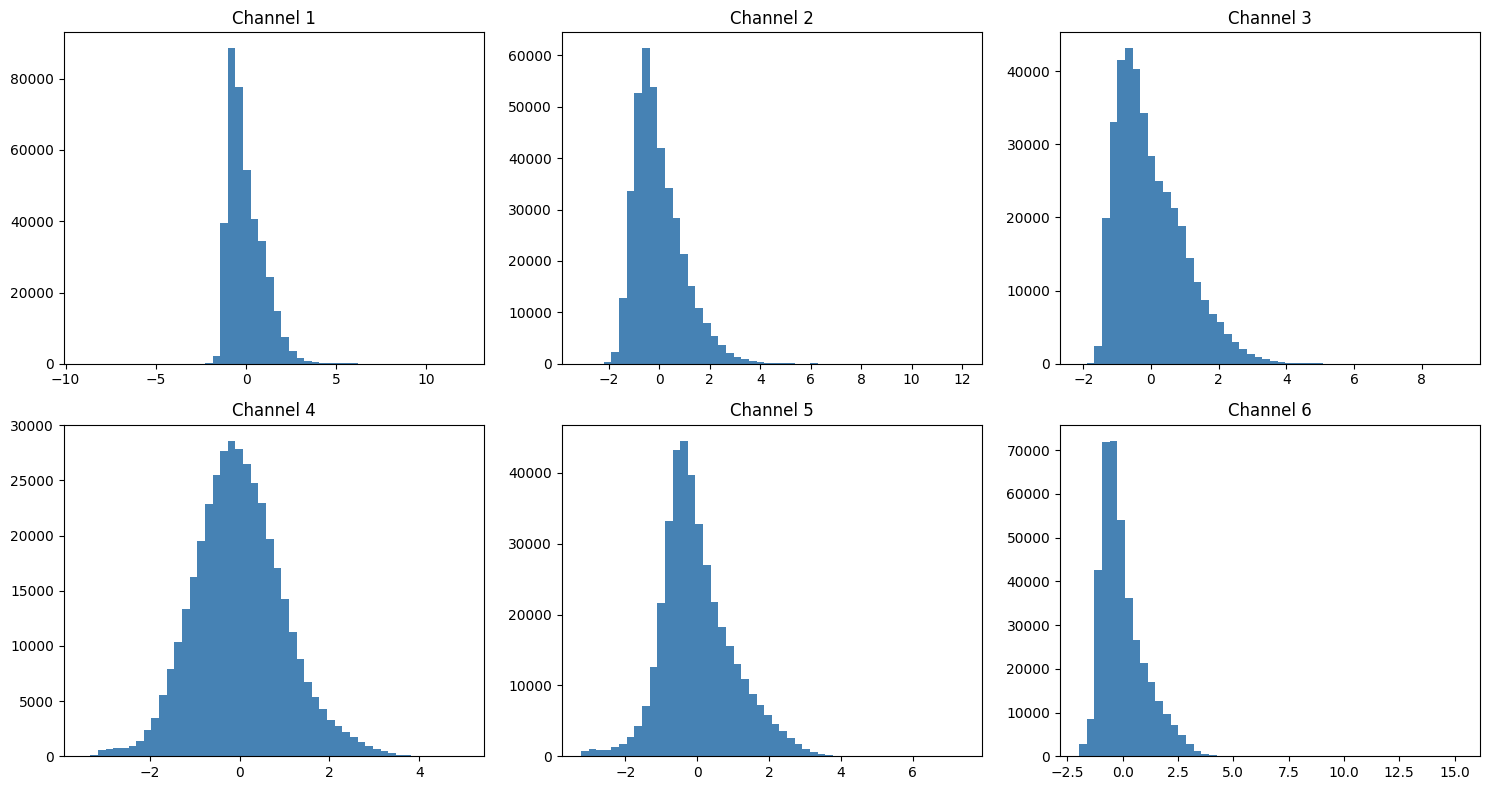



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5766      41.19%
1         2705      19.32%
2         5529      39.49%

Total samples: 14000


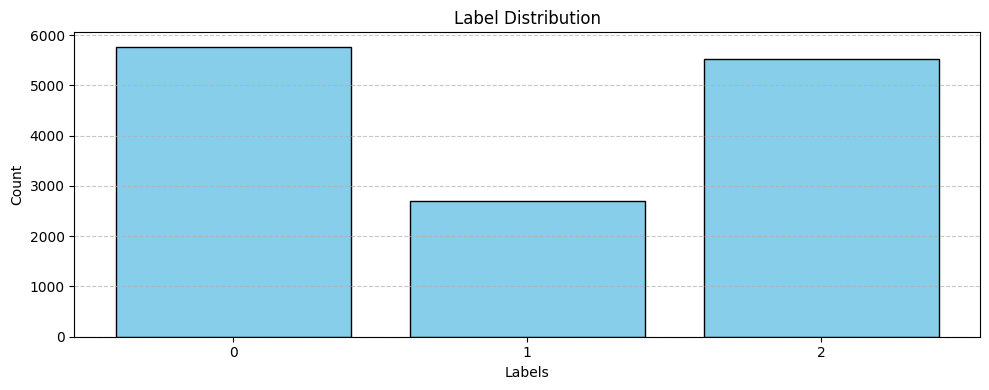


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


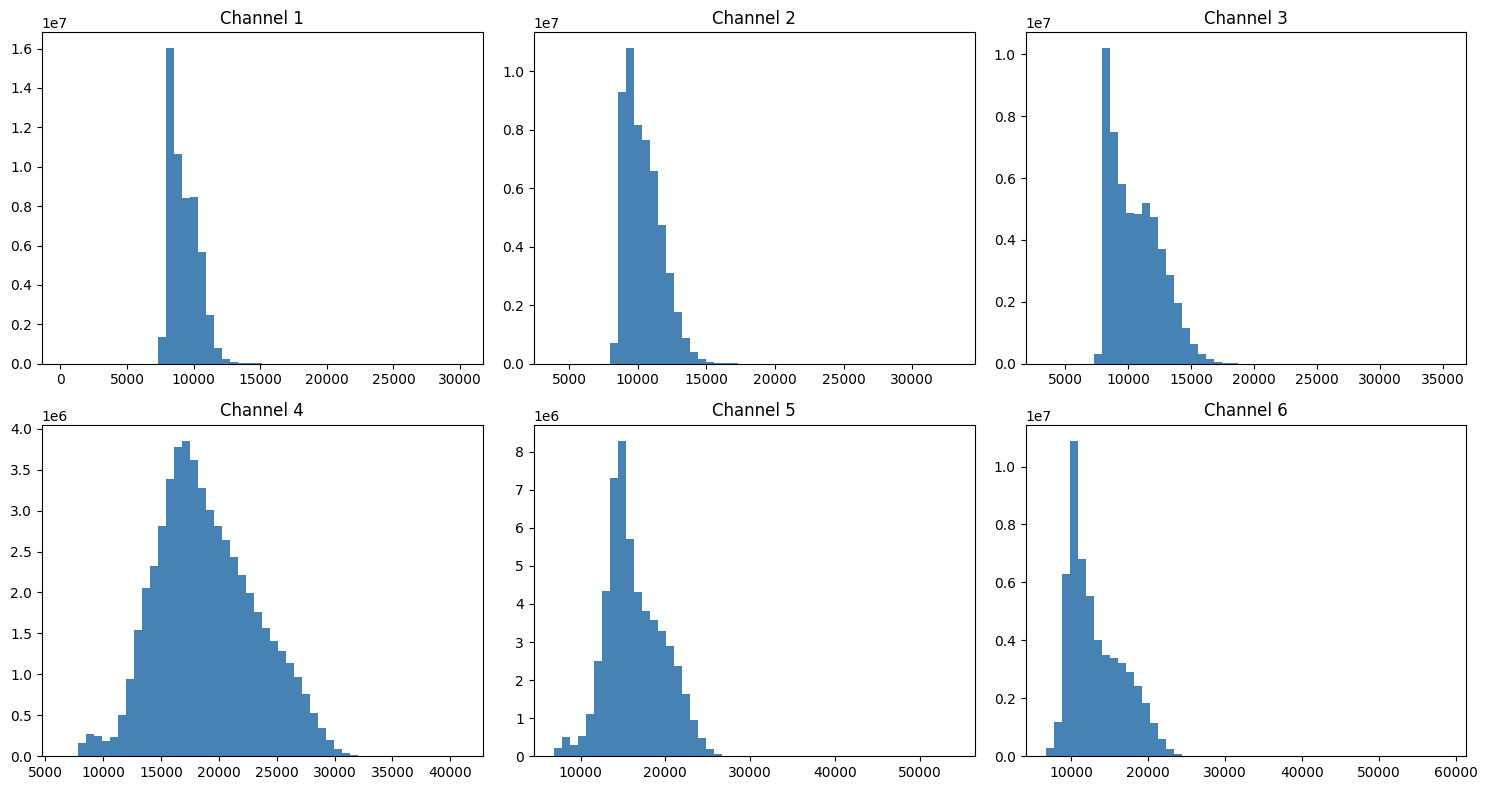

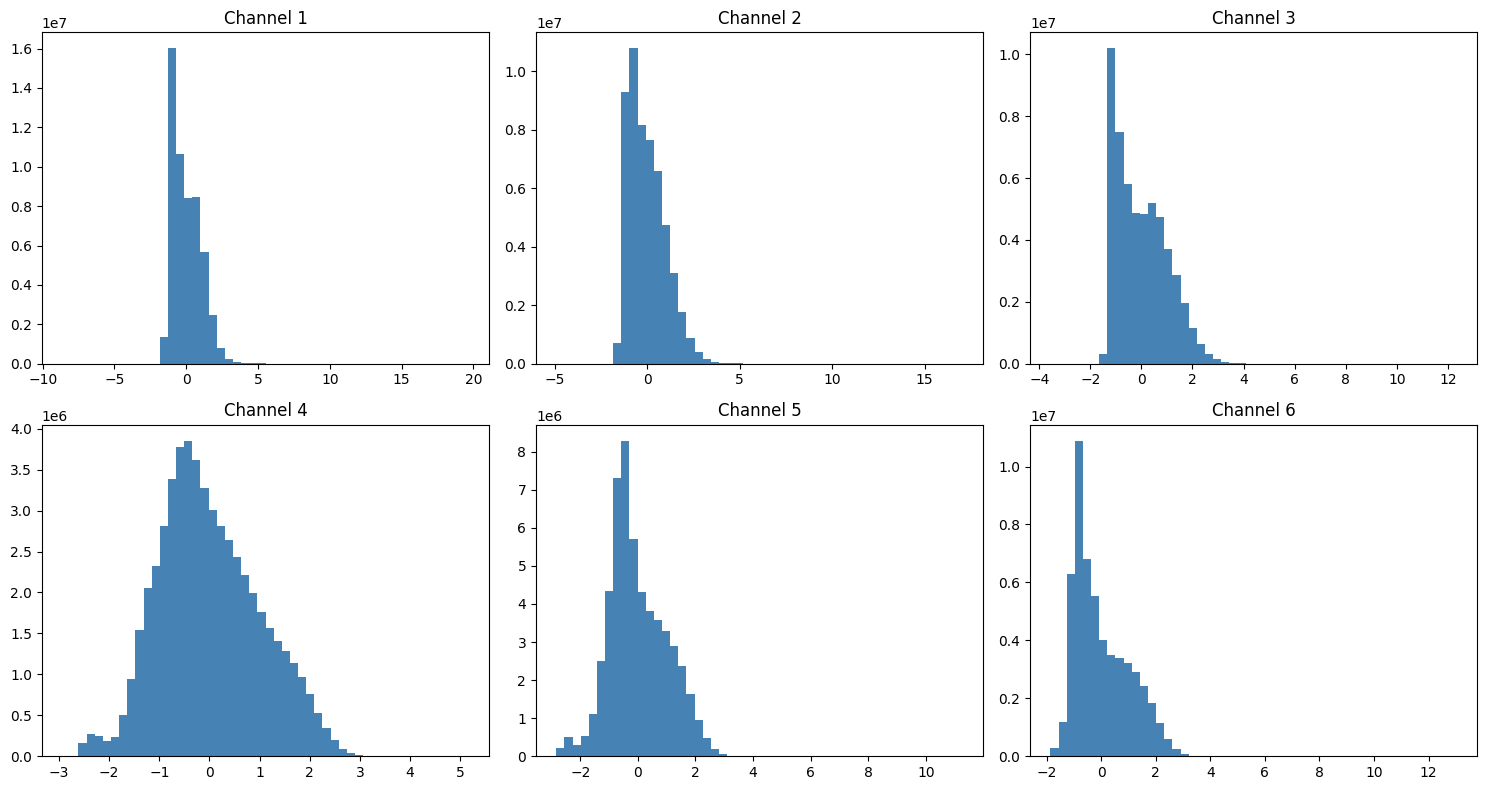



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


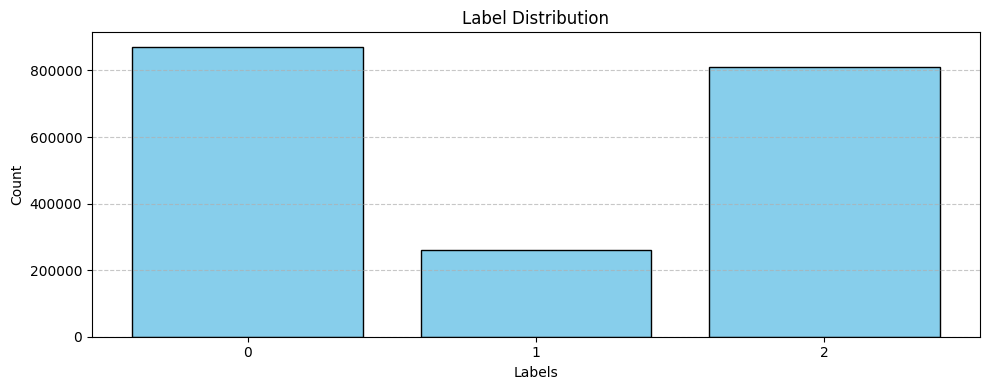

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.8093, 1.7252, 0.8440], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.7497 + 1e-07 * 2700197.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.04it/s]


Epoch [1/50] Train Loss: 1.4906, Train Acc: 0.4852 | Val Loss: 0.7964, Val Acc: 0.7851, F1: 0.7923, Kappa: 0.6517


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.9047 + 1e-07 * 2519399.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.15it/s]


Epoch [2/50] Train Loss: 1.2221, Train Acc: 0.5194 | Val Loss: 0.7219, Val Acc: 0.8208, F1: 0.8222, Kappa: 0.7094


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.9925 + 1e-07 * 2342616.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.68it/s]


Epoch [3/50] Train Loss: 1.1604, Train Acc: 0.5394 | Val Loss: 0.6900, Val Acc: 0.8384, F1: 0.8393, Kappa: 0.7372


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.9436 + 1e-07 * 2179165.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.07it/s]


Epoch [4/50] Train Loss: 1.1254, Train Acc: 0.5499 | Val Loss: 0.6578, Val Acc: 0.8359, F1: 0.8376, Kappa: 0.7338


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.8541 + 1e-07 * 2031333.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.54it/s]


Epoch [5/50] Train Loss: 1.0949, Train Acc: 0.5551 | Val Loss: 0.6303, Val Acc: 0.8431, F1: 0.8453, Kappa: 0.7452


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.8729 + 1e-07 * 1898859.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.59it/s]


Epoch [6/50] Train Loss: 1.0774, Train Acc: 0.5550 | Val Loss: 0.6139, Val Acc: 0.8495, F1: 0.8520, Kappa: 0.7551


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.7507 + 1e-07 * 1779687.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.92it/s]


Epoch [7/50] Train Loss: 1.0494, Train Acc: 0.5604 | Val Loss: 0.6077, Val Acc: 0.8368, F1: 0.8418, Kappa: 0.7349


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.8834 + 1e-07 * 1675975.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.66it/s]


Epoch [8/50] Train Loss: 1.0393, Train Acc: 0.5583 | Val Loss: 0.6268, Val Acc: 0.8273, F1: 0.8325, Kappa: 0.7190


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.7817 + 1e-07 * 1581552.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.55it/s]


Epoch [9/50] Train Loss: 1.0192, Train Acc: 0.5650 | Val Loss: 0.5354, Val Acc: 0.8590, F1: 0.8628, Kappa: 0.7704


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.67it/s]


Loss: 0.9085 + 1e-07 * 1497392.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.56it/s]


Epoch [10/50] Train Loss: 1.0060, Train Acc: 0.5744 | Val Loss: 0.5518, Val Acc: 0.8528, F1: 0.8544, Kappa: 0.7601


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.7161 + 1e-07 * 1424885.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.11it/s]


Epoch [11/50] Train Loss: 0.9958, Train Acc: 0.5702 | Val Loss: 0.5444, Val Acc: 0.8493, F1: 0.8509, Kappa: 0.7548


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.8807 + 1e-07 * 1358582.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.00it/s]


Epoch [12/50] Train Loss: 0.9737, Train Acc: 0.5762 | Val Loss: 0.5098, Val Acc: 0.8557, F1: 0.8538, Kappa: 0.7659


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 1.1120 + 1e-07 * 1297600.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.25it/s]


Epoch [13/50] Train Loss: 0.9686, Train Acc: 0.5802 | Val Loss: 0.4934, Val Acc: 0.8611, F1: 0.8611, Kappa: 0.7738


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 1.0015 + 1e-07 * 1244655.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.65it/s]


Epoch [14/50] Train Loss: 0.9636, Train Acc: 0.5801 | Val Loss: 0.4728, Val Acc: 0.8719, F1: 0.8725, Kappa: 0.7912


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.9016 + 1e-07 * 1195375.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.17it/s]


Epoch [15/50] Train Loss: 0.9533, Train Acc: 0.5799 | Val Loss: 0.5036, Val Acc: 0.8645, F1: 0.8646, Kappa: 0.7796


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 1.0389 + 1e-07 * 1153158.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.89it/s]


Epoch [16/50] Train Loss: 0.9419, Train Acc: 0.5848 | Val Loss: 0.4550, Val Acc: 0.8741, F1: 0.8737, Kappa: 0.7945


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.8119 + 1e-07 * 1112069.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.22it/s]


Epoch [17/50] Train Loss: 0.9358, Train Acc: 0.5811 | Val Loss: 0.4626, Val Acc: 0.8698, F1: 0.8680, Kappa: 0.7881


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.7766 + 1e-07 * 1075497.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.81it/s]


Epoch [18/50] Train Loss: 0.9323, Train Acc: 0.5857 | Val Loss: 0.4736, Val Acc: 0.8689, F1: 0.8684, Kappa: 0.7866


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.8888 + 1e-07 * 1042433.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.62it/s]


Epoch [19/50] Train Loss: 0.9280, Train Acc: 0.5880 | Val Loss: 0.4617, Val Acc: 0.8647, F1: 0.8655, Kappa: 0.7791


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.7511 + 1e-07 * 1013464.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.50it/s]


Epoch [20/50] Train Loss: 0.9221, Train Acc: 0.5924 | Val Loss: 0.4449, Val Acc: 0.8722, F1: 0.8738, Kappa: 0.7913


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.7967 + 1e-07 * 984956.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [21/50] Train Loss: 0.9209, Train Acc: 0.5884 | Val Loss: 0.4477, Val Acc: 0.8639, F1: 0.8632, Kappa: 0.7785


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.8534 + 1e-07 * 960737.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.99it/s]


Epoch [22/50] Train Loss: 0.9138, Train Acc: 0.5904 | Val Loss: 0.4538, Val Acc: 0.8683, F1: 0.8704, Kappa: 0.7849


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.5697 + 1e-07 * 938531.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.68it/s]


Epoch [23/50] Train Loss: 0.9081, Train Acc: 0.5918 | Val Loss: 0.4465, Val Acc: 0.8654, F1: 0.8663, Kappa: 0.7806


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.8045 + 1e-07 * 915870.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.13it/s]


Epoch [24/50] Train Loss: 0.8996, Train Acc: 0.5954 | Val Loss: 0.4250, Val Acc: 0.8678, F1: 0.8710, Kappa: 0.7840


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.7147 + 1e-07 * 896378.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.31it/s]


Epoch [25/50] Train Loss: 0.9003, Train Acc: 0.5937 | Val Loss: 0.4701, Val Acc: 0.8463, F1: 0.8490, Kappa: 0.7491


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.44it/s]


Loss: 0.9352 + 1e-07 * 878373.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.10it/s]


Epoch [26/50] Train Loss: 0.8953, Train Acc: 0.5989 | Val Loss: 0.4108, Val Acc: 0.8724, F1: 0.8745, Kappa: 0.7916


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.8344 + 1e-07 * 861412.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.45it/s]


Epoch [27/50] Train Loss: 0.8906, Train Acc: 0.5954 | Val Loss: 0.4095, Val Acc: 0.8792, F1: 0.8785, Kappa: 0.8030


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 41.34it/s]


Loss: 0.8733 + 1e-07 * 845089.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.23it/s]


Epoch [28/50] Train Loss: 0.8874, Train Acc: 0.6012 | Val Loss: 0.4319, Val Acc: 0.8686, F1: 0.8704, Kappa: 0.7856


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.7761 + 1e-07 * 831580.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.68it/s]


Epoch [29/50] Train Loss: 0.8831, Train Acc: 0.5991 | Val Loss: 0.4175, Val Acc: 0.8751, F1: 0.8769, Kappa: 0.7961


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.7264 + 1e-07 * 819152.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.73it/s]


Epoch [30/50] Train Loss: 0.8775, Train Acc: 0.6023 | Val Loss: 0.4005, Val Acc: 0.8782, F1: 0.8795, Kappa: 0.8011


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.7317 + 1e-07 * 806342.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [31/50] Train Loss: 0.8756, Train Acc: 0.6045 | Val Loss: 0.4116, Val Acc: 0.8747, F1: 0.8781, Kappa: 0.7947


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.8283 + 1e-07 * 794646.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.68it/s]


Epoch [32/50] Train Loss: 0.8729, Train Acc: 0.6049 | Val Loss: 0.4011, Val Acc: 0.8764, F1: 0.8784, Kappa: 0.7983


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.6944 + 1e-07 * 783886.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.91it/s]


Epoch [33/50] Train Loss: 0.8704, Train Acc: 0.6084 | Val Loss: 0.4173, Val Acc: 0.8651, F1: 0.8662, Kappa: 0.7801


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7562 + 1e-07 * 775842.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.22it/s]


Epoch [34/50] Train Loss: 0.8657, Train Acc: 0.6095 | Val Loss: 0.4057, Val Acc: 0.8727, F1: 0.8724, Kappa: 0.7927


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.7103 + 1e-07 * 765986.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.60it/s]


Epoch [35/50] Train Loss: 0.8703, Train Acc: 0.6006 | Val Loss: 0.4049, Val Acc: 0.8694, F1: 0.8702, Kappa: 0.7868


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.7624 + 1e-07 * 757381.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.44it/s]


Epoch [36/50] Train Loss: 0.8591, Train Acc: 0.6164 | Val Loss: 0.3939, Val Acc: 0.8749, F1: 0.8743, Kappa: 0.7961


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.6879 + 1e-07 * 749865.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.43it/s]


Epoch [37/50] Train Loss: 0.8595, Train Acc: 0.6113 | Val Loss: 0.3916, Val Acc: 0.8776, F1: 0.8771, Kappa: 0.8002


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.7839 + 1e-07 * 742650.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.93it/s]


Epoch [38/50] Train Loss: 0.8610, Train Acc: 0.6111 | Val Loss: 0.3959, Val Acc: 0.8733, F1: 0.8767, Kappa: 0.7927


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.8095 + 1e-07 * 737320.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.37it/s]


Epoch [39/50] Train Loss: 0.8580, Train Acc: 0.6117 | Val Loss: 0.3958, Val Acc: 0.8717, F1: 0.8701, Kappa: 0.7913


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.6449 + 1e-07 * 729324.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.21it/s]


Epoch [40/50] Train Loss: 0.8618, Train Acc: 0.6098 | Val Loss: 0.3883, Val Acc: 0.8725, F1: 0.8727, Kappa: 0.7925


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.7841 + 1e-07 * 723721.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.43it/s]


Epoch [41/50] Train Loss: 0.8531, Train Acc: 0.6131 | Val Loss: 0.4144, Val Acc: 0.8690, F1: 0.8714, Kappa: 0.7861


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.7687 + 1e-07 * 718167.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.88it/s]


Epoch [42/50] Train Loss: 0.8542, Train Acc: 0.6134 | Val Loss: 0.3832, Val Acc: 0.8796, F1: 0.8811, Kappa: 0.8030


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 0.7464 + 1e-07 * 712107.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.68it/s]


Epoch [43/50] Train Loss: 0.8572, Train Acc: 0.6090 | Val Loss: 0.3884, Val Acc: 0.8752, F1: 0.8738, Kappa: 0.7968


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.7327 + 1e-07 * 706486.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.93it/s]


Epoch [44/50] Train Loss: 0.8483, Train Acc: 0.6104 | Val Loss: 0.4128, Val Acc: 0.8714, F1: 0.8732, Kappa: 0.7897


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.6867 + 1e-07 * 701718.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.36it/s]


Epoch [45/50] Train Loss: 0.8476, Train Acc: 0.6137 | Val Loss: 0.4085, Val Acc: 0.8608, F1: 0.8608, Kappa: 0.7738


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.67it/s]


Loss: 0.7041 + 1e-07 * 698619.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.09it/s]


Epoch [46/50] Train Loss: 0.8413, Train Acc: 0.6177 | Val Loss: 0.3845, Val Acc: 0.8775, F1: 0.8778, Kappa: 0.7998


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.8083 + 1e-07 * 693304.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.40it/s]


Epoch [47/50] Train Loss: 0.8427, Train Acc: 0.6182 | Val Loss: 0.4120, Val Acc: 0.8653, F1: 0.8661, Kappa: 0.7807


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6883 + 1e-07 * 690728.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.60it/s]


Epoch [48/50] Train Loss: 0.8488, Train Acc: 0.6177 | Val Loss: 0.3867, Val Acc: 0.8715, F1: 0.8728, Kappa: 0.7902


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.7358 + 1e-07 * 685250.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.62it/s]


Epoch [49/50] Train Loss: 0.8400, Train Acc: 0.6163 | Val Loss: 0.3791, Val Acc: 0.8775, F1: 0.8787, Kappa: 0.7999


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.6929 + 1e-07 * 680360.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.37it/s]


Epoch [50/50] Train Loss: 0.8282, Train Acc: 0.6203 | Val Loss: 0.3809, Val Acc: 0.8778, F1: 0.8788, Kappa: 0.8004


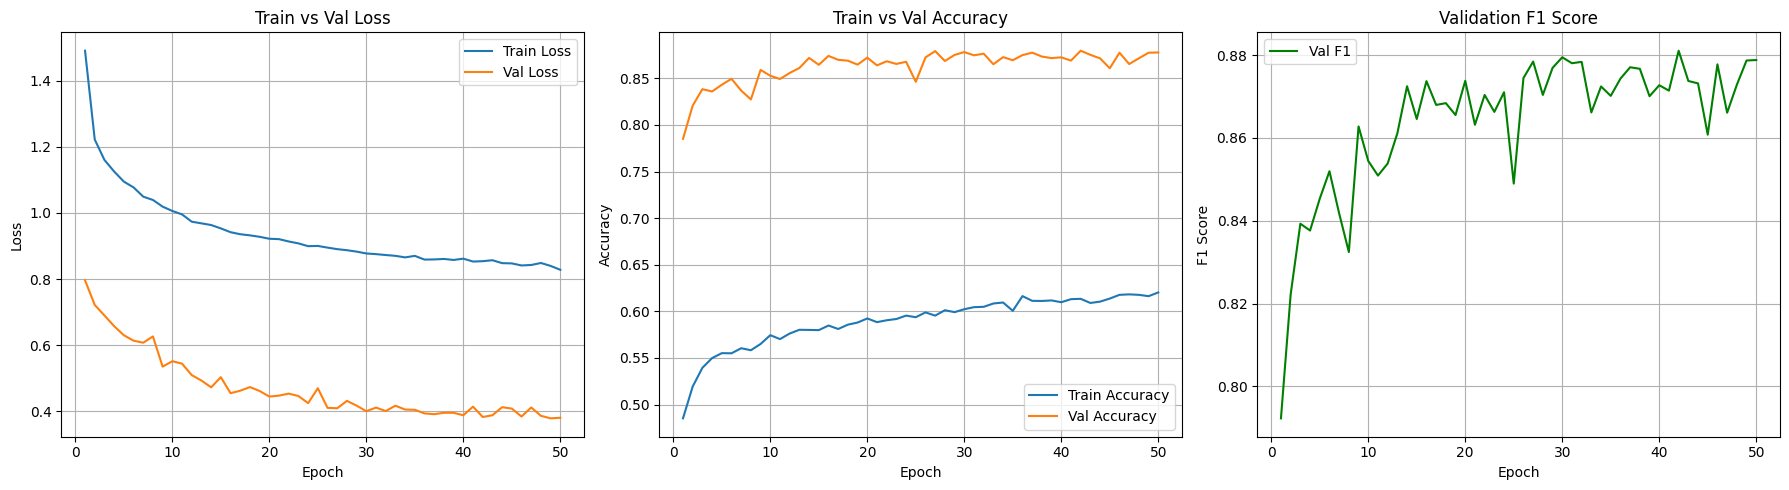


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:41<00:00, 136.32it/s]



====== Test Results ======
Overall Loss: 0.3838
Overall Accuracy: 0.8772
Cohen's Kappa: 0.7991
Per Class F1: [0.87640086 0.88764292 0.87444752]
Macro (Avg) F1: 0.8795


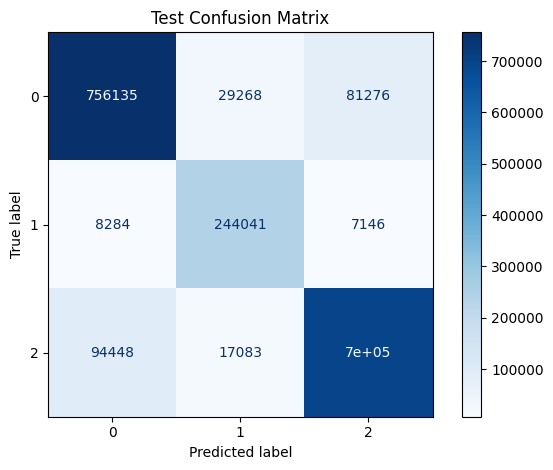

History Dumped in file /kaggle/working/approx_BCNN_data_predictive_entropy_history.json


====== Loading Data /kaggle/input/data-al/approx_BCNN_data_variation_ratio.npz ======
Train Data:  (14000, 28, 6) (14000,)


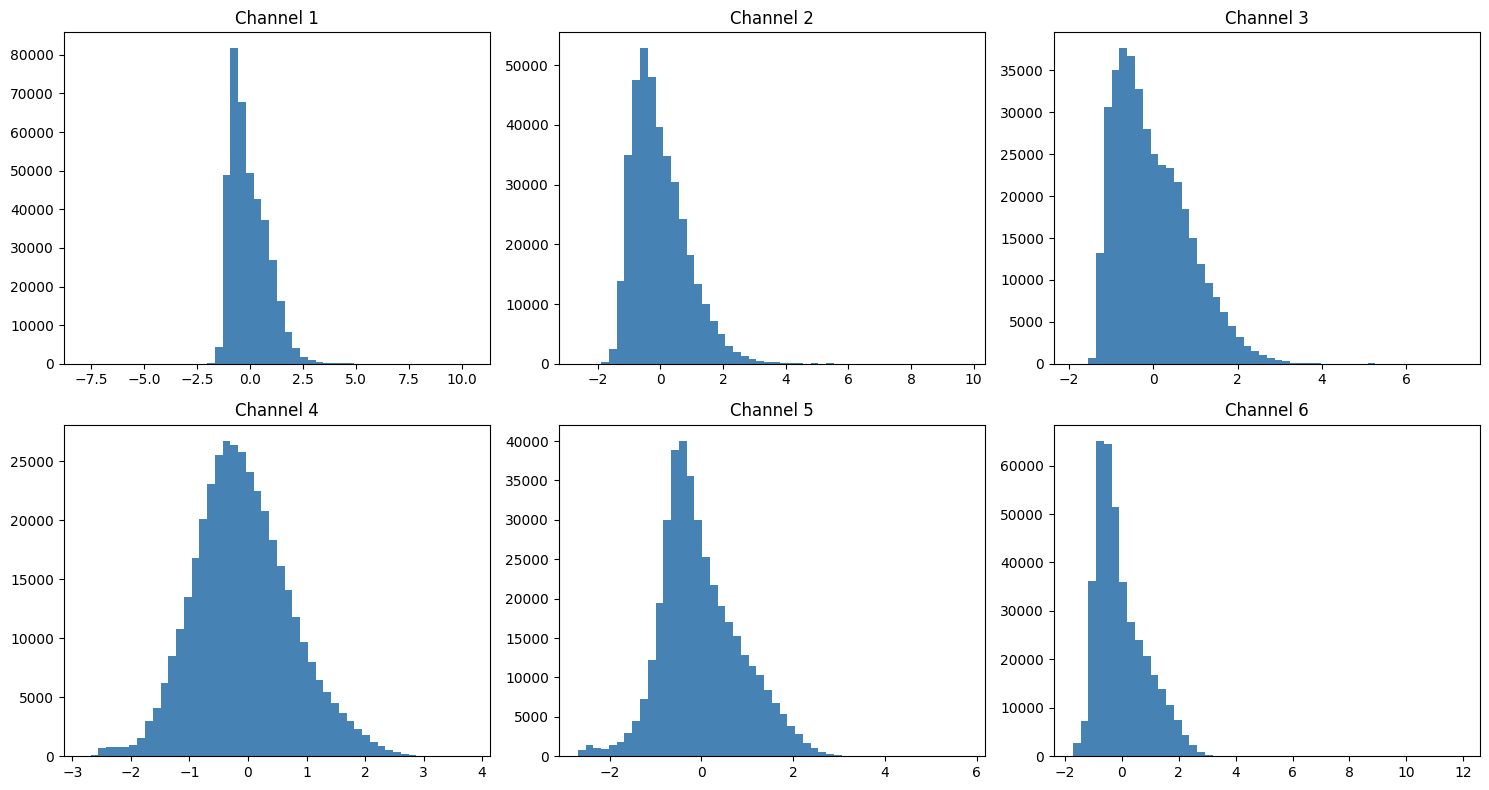

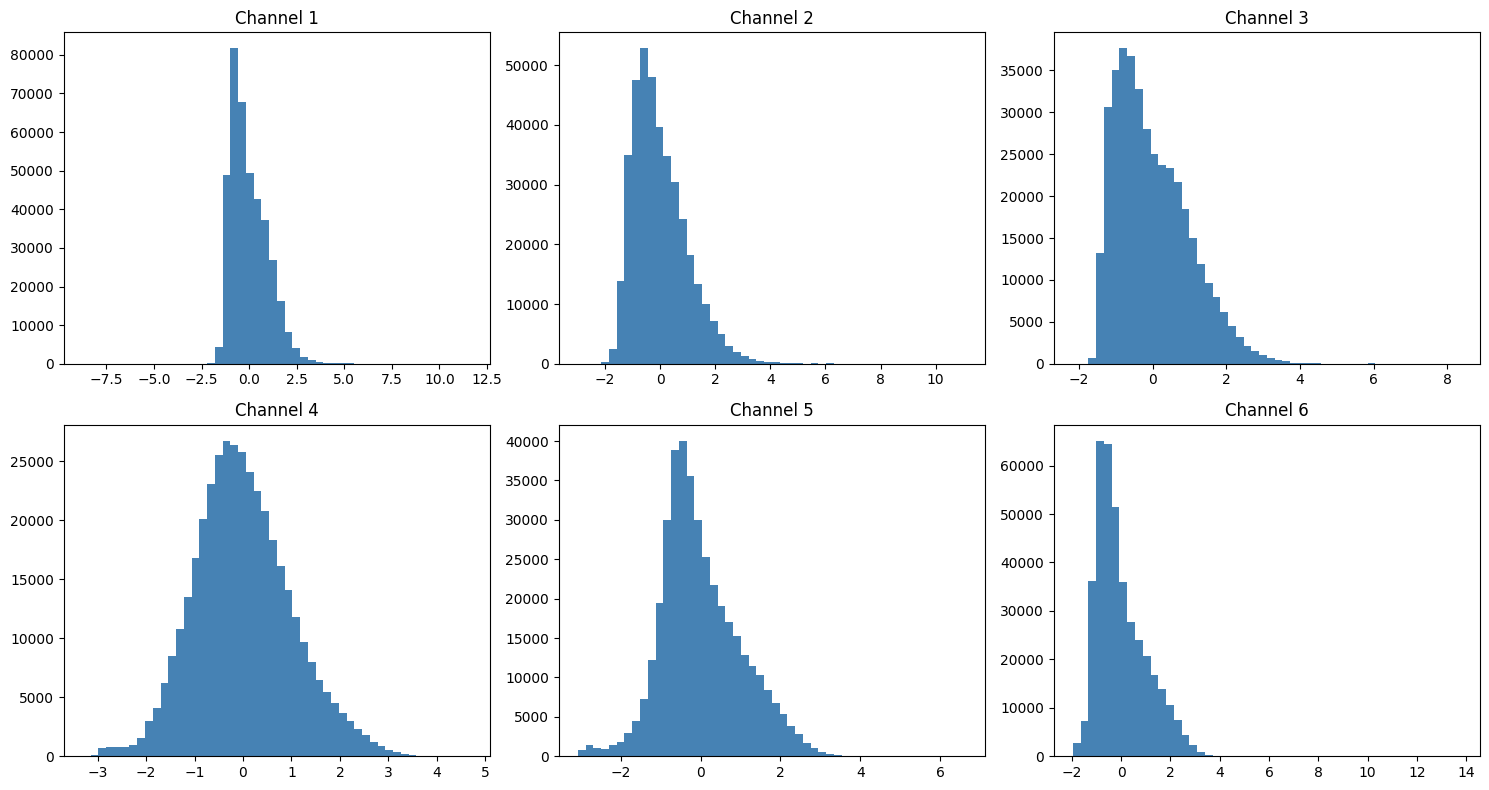



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6050      43.21%
1         1913      13.66%
2         6037      43.12%

Total samples: 14000


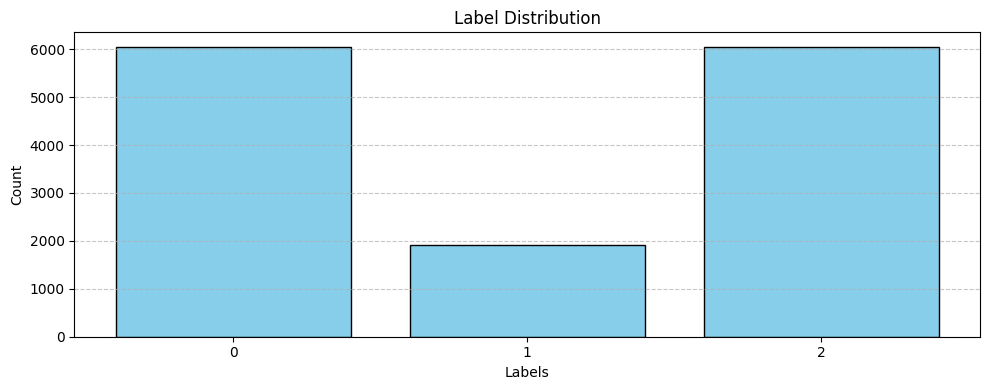


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


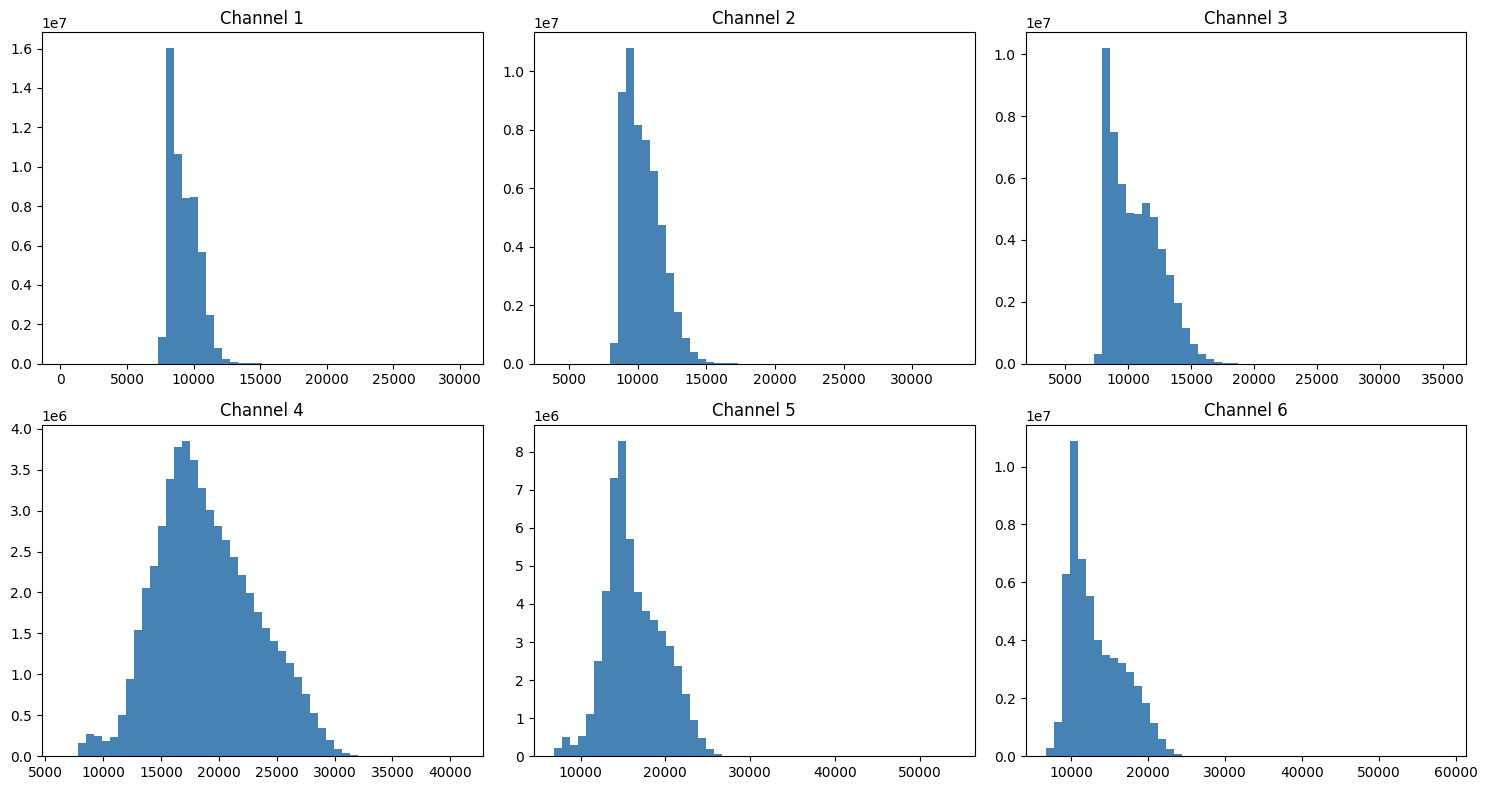

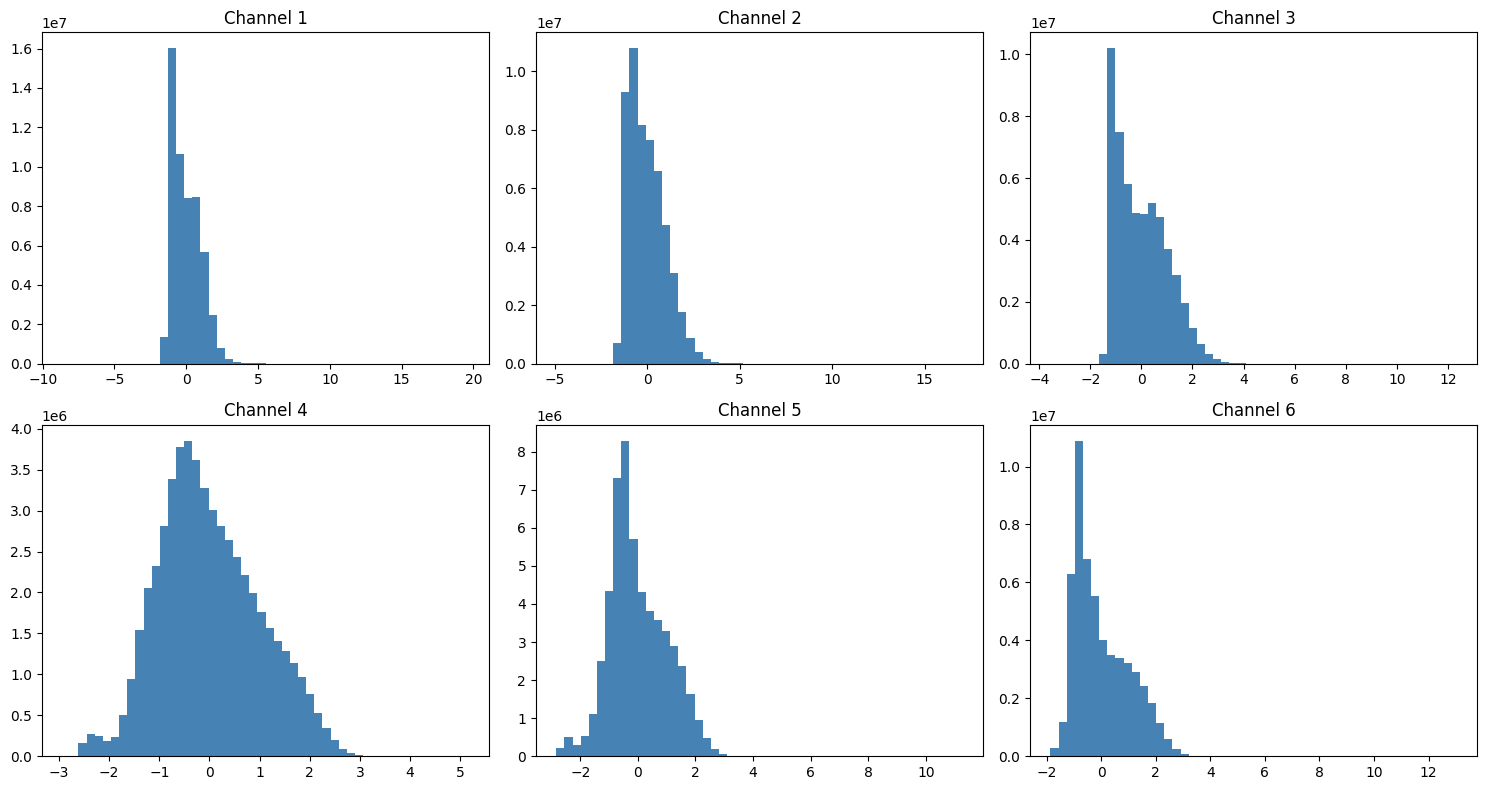



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


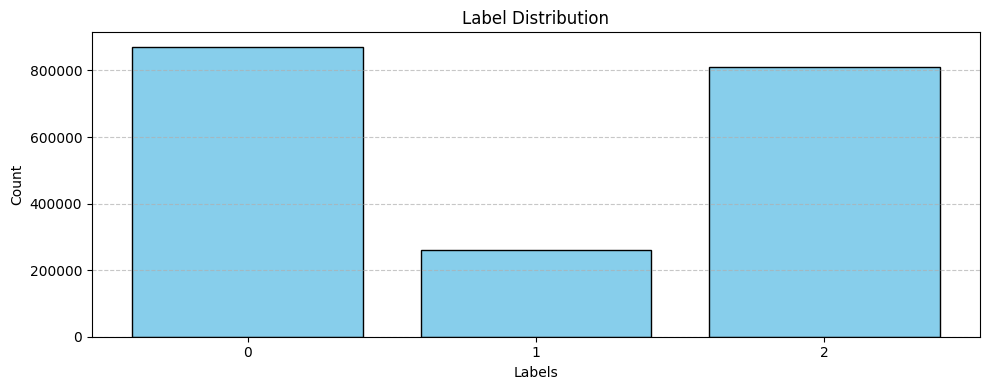

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7713, 2.4394, 0.7730], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.35it/s]


Loss: 1.0559 + 1e-07 * 2702167.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.93it/s]


Epoch [1/50] Train Loss: 1.4162, Train Acc: 0.5098 | Val Loss: 0.7376, Val Acc: 0.8123, F1: 0.8156, Kappa: 0.6949


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.8450 + 1e-07 * 2526443.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.09it/s]


Epoch [2/50] Train Loss: 1.1623, Train Acc: 0.5488 | Val Loss: 0.7169, Val Acc: 0.8371, F1: 0.8381, Kappa: 0.7347


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.8565 + 1e-07 * 2357054.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.25it/s]


Epoch [3/50] Train Loss: 1.1081, Train Acc: 0.5599 | Val Loss: 0.6540, Val Acc: 0.8544, F1: 0.8552, Kappa: 0.7630


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.8880 + 1e-07 * 2197646.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.80it/s]


Epoch [4/50] Train Loss: 1.0702, Train Acc: 0.5604 | Val Loss: 0.6270, Val Acc: 0.8749, F1: 0.8762, Kappa: 0.7951


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.7983 + 1e-07 * 2054064.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.93it/s]


Epoch [5/50] Train Loss: 1.0376, Train Acc: 0.5732 | Val Loss: 0.6081, Val Acc: 0.8683, F1: 0.8682, Kappa: 0.7855


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 1.0332 + 1e-07 * 1926303.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.73it/s]


Epoch [6/50] Train Loss: 1.0155, Train Acc: 0.5762 | Val Loss: 0.5549, Val Acc: 0.8698, F1: 0.8679, Kappa: 0.7884


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.8307 + 1e-07 * 1812947.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.81it/s]


Epoch [7/50] Train Loss: 0.9940, Train Acc: 0.5810 | Val Loss: 0.5509, Val Acc: 0.8756, F1: 0.8764, Kappa: 0.7970


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.8306 + 1e-07 * 1711365.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.69it/s]


Epoch [8/50] Train Loss: 0.9819, Train Acc: 0.5858 | Val Loss: 0.5307, Val Acc: 0.8706, F1: 0.8682, Kappa: 0.7896


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.6807 + 1e-07 * 1620165.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.66it/s]


Epoch [9/50] Train Loss: 0.9579, Train Acc: 0.5861 | Val Loss: 0.5155, Val Acc: 0.8713, F1: 0.8700, Kappa: 0.7901


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7703 + 1e-07 * 1538357.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.76it/s]


Epoch [10/50] Train Loss: 0.9397, Train Acc: 0.5979 | Val Loss: 0.5141, Val Acc: 0.8752, F1: 0.8758, Kappa: 0.7960


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.5949 + 1e-07 * 1464593.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.49it/s]


Epoch [11/50] Train Loss: 0.9330, Train Acc: 0.5979 | Val Loss: 0.4777, Val Acc: 0.8849, F1: 0.8833, Kappa: 0.8123


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 0.7739 + 1e-07 * 1398817.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.01it/s]


Epoch [12/50] Train Loss: 0.9183, Train Acc: 0.6030 | Val Loss: 0.4675, Val Acc: 0.8794, F1: 0.8771, Kappa: 0.8037


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 0.6392 + 1e-07 * 1339559.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.10it/s]


Epoch [13/50] Train Loss: 0.9001, Train Acc: 0.6080 | Val Loss: 0.4737, Val Acc: 0.8770, F1: 0.8756, Kappa: 0.7996


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.8860 + 1e-07 * 1286684.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.15it/s]


Epoch [14/50] Train Loss: 0.8964, Train Acc: 0.6078 | Val Loss: 0.4685, Val Acc: 0.8884, F1: 0.8880, Kappa: 0.8175


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.7562 + 1e-07 * 1239090.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.02it/s]


Epoch [15/50] Train Loss: 0.8898, Train Acc: 0.6039 | Val Loss: 0.4557, Val Acc: 0.8752, F1: 0.8745, Kappa: 0.7965


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7807 + 1e-07 * 1195134.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.46it/s]


Epoch [16/50] Train Loss: 0.8741, Train Acc: 0.6119 | Val Loss: 0.4397, Val Acc: 0.8904, F1: 0.8903, Kappa: 0.8208


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.9508 + 1e-07 * 1157341.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.06it/s]


Epoch [17/50] Train Loss: 0.8787, Train Acc: 0.6063 | Val Loss: 0.4337, Val Acc: 0.8872, F1: 0.8849, Kappa: 0.8163


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.8564 + 1e-07 * 1120412.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.26it/s]


Epoch [18/50] Train Loss: 0.8657, Train Acc: 0.6129 | Val Loss: 0.4258, Val Acc: 0.8852, F1: 0.8835, Kappa: 0.8127


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.7325 + 1e-07 * 1088183.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.65it/s]


Epoch [19/50] Train Loss: 0.8647, Train Acc: 0.6106 | Val Loss: 0.4306, Val Acc: 0.8800, F1: 0.8767, Kappa: 0.8048


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.6137 + 1e-07 * 1057735.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.52it/s]


Epoch [20/50] Train Loss: 0.8535, Train Acc: 0.6160 | Val Loss: 0.4112, Val Acc: 0.8848, F1: 0.8837, Kappa: 0.8120


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.7720 + 1e-07 * 1031169.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.34it/s]


Epoch [21/50] Train Loss: 0.8472, Train Acc: 0.6159 | Val Loss: 0.4348, Val Acc: 0.8836, F1: 0.8832, Kappa: 0.8101


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.6884 + 1e-07 * 1007415.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [22/50] Train Loss: 0.8480, Train Acc: 0.6227 | Val Loss: 0.4093, Val Acc: 0.8895, F1: 0.8875, Kappa: 0.8197


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.39it/s]


Loss: 0.6516 + 1e-07 * 983759.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.41it/s]


Epoch [23/50] Train Loss: 0.8342, Train Acc: 0.6227 | Val Loss: 0.4238, Val Acc: 0.8870, F1: 0.8879, Kappa: 0.8143


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.7051 + 1e-07 * 963500.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.34it/s]


Epoch [24/50] Train Loss: 0.8379, Train Acc: 0.6226 | Val Loss: 0.3919, Val Acc: 0.8891, F1: 0.8860, Kappa: 0.8193


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.7731 + 1e-07 * 943525.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.88it/s]


Epoch [25/50] Train Loss: 0.8289, Train Acc: 0.6229 | Val Loss: 0.3885, Val Acc: 0.8921, F1: 0.8898, Kappa: 0.8239


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.7910 + 1e-07 * 925147.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.98it/s]


Epoch [26/50] Train Loss: 0.8292, Train Acc: 0.6207 | Val Loss: 0.3880, Val Acc: 0.8875, F1: 0.8833, Kappa: 0.8171


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.39it/s]


Loss: 0.8400 + 1e-07 * 907033.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.53it/s]


Epoch [27/50] Train Loss: 0.8168, Train Acc: 0.6253 | Val Loss: 0.3698, Val Acc: 0.8945, F1: 0.8931, Kappa: 0.8278


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 42.22it/s]


Loss: 1.0633 + 1e-07 * 892932.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.16it/s]


Epoch [28/50] Train Loss: 0.8173, Train Acc: 0.6224 | Val Loss: 0.4048, Val Acc: 0.8941, F1: 0.8942, Kappa: 0.8265


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.8297 + 1e-07 * 880191.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.30it/s]


Epoch [29/50] Train Loss: 0.8142, Train Acc: 0.6285 | Val Loss: 0.3802, Val Acc: 0.8917, F1: 0.8904, Kappa: 0.8230


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.7334 + 1e-07 * 865984.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.53it/s]


Epoch [30/50] Train Loss: 0.8099, Train Acc: 0.6280 | Val Loss: 0.3830, Val Acc: 0.8890, F1: 0.8885, Kappa: 0.8186


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.8548 + 1e-07 * 853057.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.80it/s]


Epoch [31/50] Train Loss: 0.8136, Train Acc: 0.6331 | Val Loss: 0.3998, Val Acc: 0.8900, F1: 0.8919, Kappa: 0.8194


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.8251 + 1e-07 * 841271.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.11it/s]


Epoch [32/50] Train Loss: 0.8150, Train Acc: 0.6238 | Val Loss: 0.3810, Val Acc: 0.8918, F1: 0.8899, Kappa: 0.8233


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.43it/s]


Loss: 0.7393 + 1e-07 * 829048.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.71it/s]


Epoch [33/50] Train Loss: 0.8041, Train Acc: 0.6309 | Val Loss: 0.3819, Val Acc: 0.8874, F1: 0.8870, Kappa: 0.8163


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.8869 + 1e-07 * 820321.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.13it/s]


Epoch [34/50] Train Loss: 0.7910, Train Acc: 0.6339 | Val Loss: 0.3711, Val Acc: 0.8868, F1: 0.8857, Kappa: 0.8150


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.46it/s]


Loss: 0.5641 + 1e-07 * 812051.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.99it/s]


Epoch [35/50] Train Loss: 0.7864, Train Acc: 0.6329 | Val Loss: 0.3669, Val Acc: 0.8898, F1: 0.8905, Kappa: 0.8196


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.38it/s]


Loss: 0.7777 + 1e-07 * 804632.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.91it/s]


Epoch [36/50] Train Loss: 0.7847, Train Acc: 0.6434 | Val Loss: 0.3710, Val Acc: 0.8923, F1: 0.8923, Kappa: 0.8237


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.7186 + 1e-07 * 797661.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.37it/s]


Epoch [37/50] Train Loss: 0.7866, Train Acc: 0.6403 | Val Loss: 0.3654, Val Acc: 0.8932, F1: 0.8933, Kappa: 0.8250


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.8156 + 1e-07 * 791341.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.07it/s]


Epoch [38/50] Train Loss: 0.7820, Train Acc: 0.6424 | Val Loss: 0.3560, Val Acc: 0.8928, F1: 0.8904, Kappa: 0.8250


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.5328 + 1e-07 * 785101.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.23it/s]


Epoch [39/50] Train Loss: 0.7795, Train Acc: 0.6428 | Val Loss: 0.3947, Val Acc: 0.8897, F1: 0.8887, Kappa: 0.8189


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.44it/s]


Loss: 0.7202 + 1e-07 * 779327.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.64it/s]


Epoch [40/50] Train Loss: 0.7826, Train Acc: 0.6357 | Val Loss: 0.3618, Val Acc: 0.8889, F1: 0.8880, Kappa: 0.8187


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.34it/s]


Loss: 0.7507 + 1e-07 * 773721.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.42it/s]


Epoch [41/50] Train Loss: 0.7804, Train Acc: 0.6420 | Val Loss: 0.3440, Val Acc: 0.8932, F1: 0.8908, Kappa: 0.8259


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.6091 + 1e-07 * 768662.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.81it/s]


Epoch [42/50] Train Loss: 0.7720, Train Acc: 0.6469 | Val Loss: 0.3503, Val Acc: 0.8922, F1: 0.8902, Kappa: 0.8240


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.6879 + 1e-07 * 763369.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.03it/s]


Epoch [43/50] Train Loss: 0.7720, Train Acc: 0.6429 | Val Loss: 0.3552, Val Acc: 0.8935, F1: 0.8929, Kappa: 0.8260


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.8194 + 1e-07 * 758493.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.13it/s]


Epoch [44/50] Train Loss: 0.7688, Train Acc: 0.6444 | Val Loss: 0.3479, Val Acc: 0.8955, F1: 0.8948, Kappa: 0.8291


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.5899 + 1e-07 * 754143.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.12it/s]


Epoch [45/50] Train Loss: 0.7681, Train Acc: 0.6456 | Val Loss: 0.3597, Val Acc: 0.8908, F1: 0.8897, Kappa: 0.8214


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.7280 + 1e-07 * 749887.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.88it/s]


Epoch [46/50] Train Loss: 0.7722, Train Acc: 0.6425 | Val Loss: 0.3561, Val Acc: 0.8963, F1: 0.8978, Kappa: 0.8298


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 0.6967 + 1e-07 * 745290.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.11it/s]


Epoch [47/50] Train Loss: 0.7708, Train Acc: 0.6416 | Val Loss: 0.3608, Val Acc: 0.8951, F1: 0.8940, Kappa: 0.8283


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.8452 + 1e-07 * 742010.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.99it/s]


Epoch [48/50] Train Loss: 0.7627, Train Acc: 0.6454 | Val Loss: 0.3557, Val Acc: 0.8925, F1: 0.8907, Kappa: 0.8243


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.52it/s]


Loss: 0.6249 + 1e-07 * 738899.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.82it/s]


Epoch [49/50] Train Loss: 0.7667, Train Acc: 0.6448 | Val Loss: 0.3428, Val Acc: 0.8952, F1: 0.8936, Kappa: 0.8288


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.6792 + 1e-07 * 736054.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.83it/s]


Epoch [50/50] Train Loss: 0.7538, Train Acc: 0.6488 | Val Loss: 0.3485, Val Acc: 0.8947, F1: 0.8913, Kappa: 0.8280


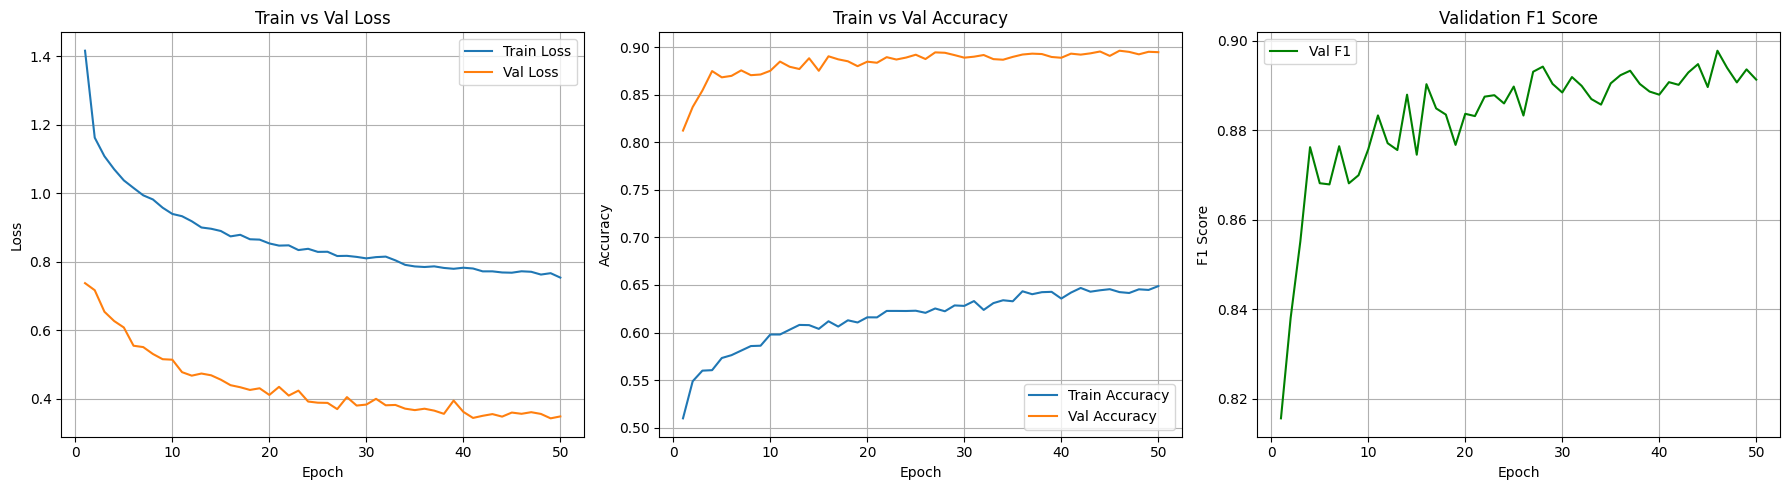


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:41<00:00, 136.54it/s]



====== Test Results ======
Overall Loss: 0.3460
Overall Accuracy: 0.8944
Cohen's Kappa: 0.8274
Per Class F1: [0.89842829 0.88695228 0.89258825]
Macro (Avg) F1: 0.8927


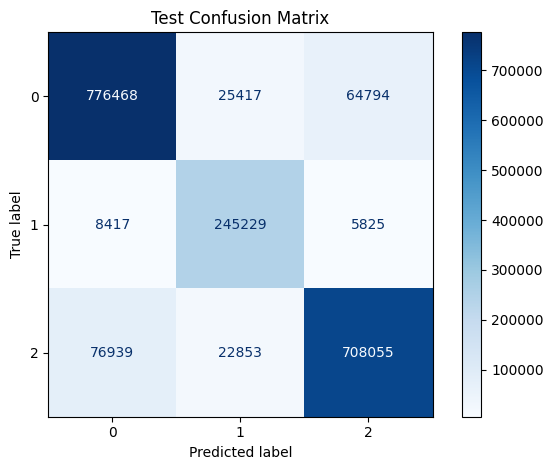

History Dumped in file /kaggle/working/approx_BCNN_data_variation_ratio_history.json
Saved history of all files to true_BCNN_training_evaluation.xlsx


In [19]:
for name in file_names:
    print(f'\n\n====== Loading Data {name} ======')
    X_train, y_train = load_data(name)

    if X_train.shape[1:] == (6,28):
        X_train = X_train.transpose(0,2,1)
        
    print('Train Data: ', X_train.shape, y_train.shape)
    plot_input_dist(X_train)
    X_train = normalize(X_train)
    plot_input_dist(X_train)
    plot_label_dist(y_train)

    print(f'\n====== Loading Data Site {SITE} - {YEAR} ======')
    X_B2020, y_B2020 = load_data(X_B2020_path, y_B2020_path)
    print(f'Site {SITE} - {YEAR} Data: {X_B2020.shape}, {y_B2020.shape}')
    plot_input_dist(X_B2020)
    X_B2020 = normalize(X_B2020)
    plot_input_dist(X_B2020)
    plot_label_dist(y_B2020)

    # Data Split
    X_test, X_val, y_test, y_val = train_test_split(X_B2020, y_B2020, test_size=0.005, stratify=y_B2020, random_state=42)
    print(f'Val Data: ', X_val.shape, y_val.shape)
    print(f'Test Data: ', X_test.shape, y_test.shape)

    # Creating datasets and dataloaders
    train_dataset = Conv1dDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = Conv1dDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = Conv1dDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model Initialization
    model = BayesianCNN_FC(priors=PRIORS, num_classes=3, device=DEVICE).to(DEVICE)
    ckpt = torch.load('/kaggle/input/b_cnn/pytorch/default/1/BCNN.pth', map_location='cpu')
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        state = ckpt['model_state_dict']
    else:
        state = ckpt
    
    new_state = {}
    for k, v in state.items():
        if k.startswith("_orig_mod."):
            new_state[k.replace("_orig_mod.", "")] = v
        else:
            new_state[k] = v
    model.load_state_dict(new_state, strict=True)

    # ===== Class weights =====
    all_labels = []
    for _, y_batch in train_dataloader:
        all_labels.append(y_batch.numpy())
    
    all_labels = np.concatenate(all_labels)
    classes = np.unique(all_labels)
    class_weights_np = compute_class_weight(class_weight='balanced',
                                            classes=classes, y=all_labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
    print("Class weights:", class_weights)

    print(f'\n====== Training the Model ======')
    train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s = train(model, train_dataset, train_dataloader, val_dataset, val_dataloader, class_weights, EPOCHS=EPOCHS, T=T)
    plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS)

    print(f'\n====== Testing the Model ======')
    loss, acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, class_weights=class_weights, T=T, device=DEVICE)

    # Printing
    print(f'\n====== Test Results ======')
    print(f'Overall Loss: {loss:.4f}')
    print(f'Overall Accuracy: {acc:.4f}')
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f'Per Class F1: {per_class_f1}')
    print(f"Macro (Avg) F1: {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Test Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Logging History
    history[name]['train_loss'] = train_losses
    history[name]['train_acc'] = train_accs
    history[name]['val_loss'] = val_losses
    history[name]['val_acc'] = val_accs
    history[name]['val_f1s'] = val_f1s
    history[name]['val_kappas'] = val_kappas
    history[name]['val_per_class_f1s'] = val_per_class_f1s
    
    history[name]['overall_loss'] = float(loss)
    history[name]['overall_acc'] = float(acc)
    history[name]['kappa'] = float(kappa)
    history[name]['per_class_f1'] = per_class_f1.tolist() if isinstance(per_class_f1, (np.ndarray, list)) else per_class_f1
    history[name]['avg_f1'] = float(avg_f1)
    history[name]['cm'] = cm.tolist() if hasattr(cm, "tolist") else cm

    # Dumping
    save_history(history[name], name)

    
# Saving the Results
save_results('true_BCNN_training_evaluation', history)

<hr>